In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/data --> file path (cd)


In [2]:

import pandas as pd

# Step 1: Set the file path
file_path = '/content/drive/MyDrive/Dataset/FYP_Final_Data.csv'

# Step 2: Load the CSV file
df = pd.read_csv(file_path)

# Step 3: Display the first few rows
df.head()


Month    Year      Product  Volume FOB_value_000 Avg_FOB\n
0   Jan  2015.0  Coconut Oil  297.00       1582.91   5330.00
1   Feb  2015.0  Coconut Oil  920.00       5155.27   5604.00
2   Mar  2015.0  Coconut Oil  858.00       4861.04   5666.00
3   Apr  2015.0  Coconut Oil  780.00       4549.35   5833.00
4   May  2015.0  Coconut Oil  847.00       5226.68   6171.00

# Data Preprocessing


In [3]:
# Clean column names
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace(r"[^\w\s]", '', regex=True)
df.columns

# Check for missing or placeholder values
missing_counts = df.isin(['', ' ', 'N/A', 'NaN', 'None']).sum()
print("Missing (placeholder) values:\n", missing_counts)

# Also check actual NaNs
print("\nActual NaNs:\n", df.isnull().sum())

df['Product'] = df['Product'].str.strip()
df['Month'] = df['Month'].str.strip()

import pandas as pd

# Convert Month names to numbers, coercing errors to NaT
df['Month_Num'] = pd.to_datetime(df['Month'], format='%b', errors='coerce').dt.month

# Combine Year and Month into a Date column, coercing errors to NaT
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month_Num'], day=1), errors='coerce')

# Check for any unparsed months or dates
unparsed_months = df[df['Month_Num'].isnull()]['Month'].unique()
if len(unparsed_months) > 0:
    print(f"Warning: The following month names could not be parsed and resulted in NaNs: {list(unparsed_months)}")
    print("Consider cleaning these entries in the 'Month' column.")

unparsed_dates_count = df['Date'].isnull().sum()
if unparsed_dates_count > 0:
    print(f"Warning: {unparsed_dates_count} dates could not be fully constructed due to parsing errors or missing Year/Month data.")

# Correct the 'Sept' typo to 'Sep'
df['Month'] = df['Month'].replace('Sept', 'Sep')
print("Corrected 'Sept' to 'Sep' in the 'Month' column.")

# Re-run the date conversion after correcting the month name
df['Month_Num'] = pd.to_datetime(df['Month'], format='%b', errors='coerce').dt.month
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month_Num'], day=1), errors='coerce')

unparsed_months_after_correction = df[df['Month_Num'].isnull()]['Month'].unique()
if len(unparsed_months_after_correction) > 0:
    print(f"Warning after correction: The following month names still could not be parsed: {list(unparsed_months_after_correction)}")
else:
    print("All month names parsed successfully after correction.")

unparsed_dates_count_after_correction = df['Date'].isnull().sum()
if unparsed_dates_count_after_correction > 0:
    print(f"Warning after correction: {unparsed_dates_count_after_correction} dates could not be fully constructed.")
else:
    print("All dates constructed successfully after correction.")

print("Total rows:", len(df))

df = df.drop(columns=['Month', 'Month_Num'])

df['FOB_Value_USD'] = df['FOB_value_000'] * 1000

# Safely convert to numeric just in case, then multiply
df['FOB_Value_USD'] = pd.to_numeric(df['FOB_value_000'], errors='coerce') * 1000

# Check the result
df[['FOB_value_000', 'FOB_Value_USD']].head()

df.drop(columns=['FOB_value_000'], inplace=True)

er_df = pd.read_csv('/content/drive/MyDrive/Dataset/Exchange Rate - Coconut.csv')
er_df.head()

import calendar

er_df['Month'] = er_df['Month'].apply(lambda x: calendar.month_abbr[list(calendar.month_name).index(x)])

df['Month'] = df['Date'].dt.strftime('%b')  # Jan, Feb, etc.
df['Year'] = df['Date'].dt.year

df['Year'] = df['Year'].astype(int)
df.head()

# Ensure column names of er_df are clean (strip any whitespace)
er_df.columns = er_df.columns.str.strip()

merged_df_er = pd.merge(df, er_df, on=['Year', 'Month'], how='left')

merged_df_er.head()

fresh_df = pd.read_csv('/content/drive/MyDrive/Dataset/Cleaned_Fresh_Nut_Consumption.csv')
fresh_df.head()

merged_df_fresh = pd.merge(merged_df_er, fresh_df, on=['Year', 'Month'], how='left')

merged_df_fresh.head()

# Convert Fresh_Nut_Million to actual numbers by multiplying by 1,000,000
merged_df_fresh['Fresh_Nut_Actual'] = merged_df_fresh['Fresh_Nut_Million'] * 1_000_000

# Display the head of the DataFrame to show the new column
merged_df_fresh.head()

merged_df_fresh.info()

local_price_df = pd.read_csv('/content/drive/MyDrive/Dataset/Coconut_local_price.csv')
local_price_df.head()

local_price_df.info()

merged_df_fresh_local = pd.merge(merged_df_fresh, local_price_df, on=['Year', 'Month'], how='left')
merged_df_fresh_local.head()

# Convert 'Volume' and 'Avg_FOB' to numeric, coercing errors to NaN
merged_df_fresh_local['Volume'] = pd.to_numeric(merged_df_fresh_local['Volume'], errors='coerce')
merged_df_fresh_local['Avg_FOB'] = pd.to_numeric(merged_df_fresh_local['Avg_FOB'], errors='coerce')

print("Data types after conversion:")
merged_df_fresh_local[['Volume', 'Avg_FOB', 'FOB_Value_USD']].info()

merged_df_fresh_local.head()

print("\n--- Missing Values by Variable (Overall) ---")
missing_overall = merged_df_fresh_local.isnull().sum()
print(missing_overall[missing_overall > 0])

print("\n--- Missing Values by Variable and Product ---")
missing_by_product = merged_df_fresh_local.groupby('Product').apply(lambda x: x.isnull().sum())
# Filter to show only columns with missing values for at least one product
missing_by_product = missing_by_product.loc[:, (missing_by_product != 0).any(axis=0)]

if not missing_by_product.empty:
    display(missing_by_product)
else:
    print("No missing values found when grouped by product.")

# Clean placeholders in target columns
merged_df_fresh_local[['Volume', 'Avg_FOB', 'FOB_Value_USD']] = merged_df_fresh_local[
    ['Volume', 'Avg_FOB', 'FOB_Value_USD']
].replace(['-', '', ' '], pd.NA)

# Convert columns to numeric
merged_df_fresh_local['Volume'] = pd.to_numeric(merged_df_fresh_local['Volume'], errors='coerce')
merged_df_fresh_local['Avg_FOB'] = pd.to_numeric(merged_df_fresh_local['Avg_FOB'], errors='coerce')
merged_df_fresh_local['FOB_Value_USD'] = pd.to_numeric(merged_df_fresh_local['FOB_Value_USD'], errors='coerce')

# Define the fill function


Missing (placeholder) values:
 Month            0
Year             0
Product          0
Volume           0
FOB_value_000    0
Avg_FOB          0
dtype: int64

Actual NaNs:
 Month             0
Year              0
Product           0
Volume           60
FOB_value_000    60
Avg_FOB          60
dtype: int64
Consider cleaning these entries in the 'Month' column.
Corrected 'Sept' to 'Sep' in the 'Month' column.
All month names parsed successfully after correction.
All dates constructed successfully after correction.
Total rows: 1440
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               1440 non-null   int64         
 1   Product            1440 non-null   object        
 2   Volume             1380 non-null   object        
 3   Avg_FOB            1380 non-null   object        
 4   Date               1440 

/tmp/ipython-input-2794234554.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_product = merged_df_fresh_local.groupby('Product').apply(lambda x: x.isnull().sum())


Volume  Avg_FOB  FOB_Value_USD  Coconut_local_price
Product                                                                 
Coconut Cream             0        0              0                    6
Coconut Flour            12       12             12                    6
Coconut Milk              0        0              0                    6
Coconut Milk Powder       0        0              0                    6
Coconut Oil               0        0              0                    6
Coconut Water            12       12             12                    6
Copra                     4        7              4                    6
Defatted Coconut         12       12             12                    6
Desiccated Coconut        0        0              0                    6
Dessicated Coconut        0        0              0                    0
Fresh Coconut            16       16             16                    6
King Coconut             12       12             12                    6
Virgin Coconut Oil       12       12             12                    6

In [4]:
def fill_by_month_product_median(row, col):
    if pd.isna(row[col]):
        product = row['Product']
        month = row['Month']
        year = row['Year']
        median_val = merged_df_fresh_local[
            (merged_df_fresh_local['Product'] == product) &
            (merged_df_fresh_local['Month'] == month) &
            (merged_df_fresh_local['Year'] != year)
        ][col].median()
        return median_val
    else:
        return row[col]

# Fill missing values for Volume and Avg_FOB
merged_df_fresh_local['Volume'] = merged_df_fresh_local.apply(
    lambda row: fill_by_month_product_median(row, 'Volume'), axis=1
)
merged_df_fresh_local['Avg_FOB'] = merged_df_fresh_local.apply(
    lambda row: fill_by_month_product_median(row, 'Avg_FOB'), axis=1
)

# Recalculate FOB_Value_USD
merged_df_fresh_local['FOB_Value_USD'] = merged_df_fresh_local['Volume'] * merged_df_fresh_local['Avg_FOB']

# Check missing values
print(merged_df_fresh_local[['Volume', 'Avg_FOB', 'FOB_Value_USD']].isnull().sum())

merged_df_fresh_local["Date"] = pd.to_datetime(
    merged_df_fresh_local["Date"], errors="coerce"
)

merged_df_fresh_local = (
    merged_df_fresh_local
    .sort_values(["Product", "Date"])
    .reset_index(drop=True)
)

#Date and numeric columns were standardised and validated to ensure
#chronological consistency and numerical integrity prior to time-series analysis and modelling

merged_df_fresh_local["Date"] = pd.to_datetime(
    merged_df_fresh_local["Date"], errors="coerce"
)

merged_df_fresh_local = (
    merged_df_fresh_local
    .sort_values(["Product", "Date"])
    .reset_index(drop=True)
)

num_cols = [
    "Volume", "Avg_FOB", "FOB_Value_USD", "USD",
    "Fresh_Nut_Million", "Fresh_Nut_Actual", "Coconut_local_price"
]

for c in num_cols:
    merged_df_fresh_local[c] = pd.to_numeric(
        merged_df_fresh_local[c], errors="coerce"
    )

num_cols = [
    "Volume", "Avg_FOB", "FOB_Value_USD", "USD",
    "Fresh_Nut_Million", "Fresh_Nut_Actual", "Coconut_local_price"
]

for c in num_cols:
    merged_df_fresh_local[c] = pd.to_numeric(
        merged_df_fresh_local[c], errors="coerce"
    )

# fixing the missing values for coconut local price -nearby months of same product
merged_df_fresh_local["Coconut_local_price"] = (
    merged_df_fresh_local
    .groupby("Product")["Coconut_local_price"]
    .apply(lambda s: s.ffill().bfill())
    .reset_index(level=0, drop=True)
)

merged_df_fresh_local["Year"] = merged_df_fresh_local["Date"].dt.year
merged_df_fresh_local["Month"] = merged_df_fresh_local["Date"].dt.month

# Standardise product naming
merged_df_fresh_local["Product"] = (
    merged_df_fresh_local["Product"]
    .replace({
        "Dessicated Coconut": "Desiccated Coconut",
        "Desicted Coconut": "Desiccated Coconut"
    })
)

# Verify
merged_df_fresh_local["Product"].value_counts()

# Cyclical Encoding - Dec and Jan being close to each other
import numpy as np
merged_df_fresh_local["Month_sin"] = np.sin(
    2 * np.pi * merged_df_fresh_local["Month"] / 12
)

merged_df_fresh_local["Month_cos"] = np.cos(
    2 * np.pi * merged_df_fresh_local["Month"] / 12
)

# One-hot encoding for products --> cannot interpret text numbers
merged_df_preprocessed = pd.get_dummies(
    merged_df_fresh_local,
    columns=["Product"],
    prefix="Product",
    drop_first=False
)

merged_df_preprocessed = (
    merged_df_preprocessed
    .dropna(subset=["Date", "Volume"])
    .reset_index(drop=True)
)

merged_df_fresh_local[
    (merged_df_fresh_local["Year"] != merged_df_fresh_local["Date"].dt.year) |
    (merged_df_fresh_local["Month"] != merged_df_fresh_local["Date"].dt.month)
]

# ensuring that values are numerically
merged_df_fresh_local[["Month", "Month_sin", "Month_cos"]].head(12)

print(
    merged_df_fresh_local[["Month_sin", "Month_cos"]].min(),
    merged_df_fresh_local[["Month_sin", "Month_cos"]].max()
)

product_cols = [c for c in merged_df_preprocessed.columns if c.startswith("Product_")]

# Check one-hot correctness
merged_df_preprocessed[product_cols].sum(axis=1).value_counts()

print("Missing Volume:", merged_df_preprocessed["Volume"].isna().sum())
print("Negative Volume:", (merged_df_preprocessed["Volume"] < 0).sum())

merged_df_preprocessed["Volume"].describe()

print("Date type:", merged_df_fresh_local["Date"].dtype)
print("\nMissing values:\n", merged_df_fresh_local.isna().sum())

product_cols = [c for c in merged_df_preprocessed.columns if c.startswith("Product_")]
print("\nOne-hot product check:\n", merged_df_preprocessed[product_cols].sum(axis=1).value_counts())

print("\nVolume stats:\n", merged_df_preprocessed["Volume"].describe())

output_path_preprocessed = '/content/drive/MyDrive/Dataset/FYP_Preprocessed_Data.csv'
merged_df_preprocessed.to_csv(output_path_preprocessed, index=False)
print(f"DataFrame successfully saved to {output_path_preprocessed}")


Volume           0
Avg_FOB          0
FOB_Value_USD    0
dtype: int64
Month_sin   -1.0
Month_cos   -1.0
dtype: float64 Month_sin    1.0
Month_cos    1.0
dtype: float64
Missing Volume: 0
Negative Volume: 0
Date type: datetime64[ns]

Missing values:
 Year                   0
Product                0
Volume                 0
Avg_FOB                0
Date                   0
FOB_Value_USD          0
Month                  0
USD                    0
Fresh_Nut_Million      0
Fresh_Nut_Actual       0
Coconut_local_price    0
Month_sin              0
Month_cos              0
dtype: int64

One-hot product check:
 1    1440
Name: count, dtype: int64

Volume stats:
 count    1440.000000
mean     1207.406833
std      1281.241521
min         0.040000
25%       329.000000
50%       678.000000
75%      1634.250000
max      8643.000000
Name: Volume, dtype: float64
DataFrame successfully saved to /content/drive/MyDrive/Dataset/FYP_Preprocessed_Data.csv


Feature Engineering

My updated df is merged_df_preprocessed


In [5]:

product_cols = [c for c in merged_df_preprocessed.columns if c.startswith("Product_")]
product_cols

# Sort by product & date before lagging
merged_df_preprocessed = (
    merged_df_preprocessed
    .sort_values(["Date"])
    .reset_index(drop=True)
)

# Create lag features
merged_df_preprocessed["Volume_lag_1"] = merged_df_preprocessed["Volume"].shift(1)
merged_df_preprocessed["Volume_lag_3"] = merged_df_preprocessed["Volume"].shift(3)

merged_df_preprocessed["USD_lag_1"] = merged_df_preprocessed["USD"].shift(1)
merged_df_preprocessed["Avg_FOB_lag_1"] = merged_df_preprocessed["Avg_FOB"].shift(1)

# Rolling averages (short & medium term trends)
merged_df_preprocessed["Volume_3m_avg"] = (
    merged_df_preprocessed["Volume"]
    .rolling(window=3)
    .mean()
)

merged_df_preprocessed["Avg_FOB_6m_avg"] = (
    merged_df_preprocessed["Avg_FOB"]
    .rolling(window=6)
    .mean()
)

# Rolling volatility (market instability)
merged_df_preprocessed["USD_3m_std"] = (
    merged_df_preprocessed["USD"]
    .rolling(window=3)
    .std()
)

merged_df_preprocessed["USD_x_AvgFOB"] = (
    merged_df_preprocessed["USD"] * merged_df_preprocessed["Avg_FOB"]
)

# Drop initial rows where lag/rolling features are NaN
merged_df_fe = merged_df_preprocessed.dropna().reset_index(drop=True)

merged_df_fe.shape

merged_df_fe.info()
merged_df_fe.head()

# Identify product columns
product_cols = [c for c in merged_df_preprocessed.columns if c.startswith("Product_")]

# Reconstruct Product label from one-hot encoding
merged_df_preprocessed["Product"] = (
    merged_df_preprocessed[product_cols]
    .idxmax(axis=1)
)

# Sort before lagging (important)
merged_df_preprocessed = (
    merged_df_preprocessed
    .sort_values(["Product", "Date"])
    .reset_index(drop=True)
)

# Product-wise lag
merged_df_preprocessed["Volume_lag_1"] = (
    merged_df_preprocessed
    .groupby("Product")["Volume"]
    .shift(1)
)

merged_df_preprocessed[
    ["Product", "Date", "Volume", "Volume_lag_1"]
].head(10)

merged_df_fe = merged_df_preprocessed.dropna().reset_index(drop=True)
merged_df_fe.shape

merged_df_preprocessed.groupby("Product").size()
merged_df_fe.groupby("Product").size()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1435 entries, 0 to 1434
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Year                         1435 non-null   int32         
 1   Volume                       1435 non-null   float64       
 2   Avg_FOB                      1435 non-null   float64       
 3   Date                         1435 non-null   datetime64[ns]
 4   FOB_Value_USD                1435 non-null   float64       
 5   Month                        1435 non-null   int32         
 6   USD                          1435 non-null   float64       
 7   Fresh_Nut_Million            1435 non-null   float64       
 8   Fresh_Nut_Actual             1435 non-null   float64       
 9   Coconut_local_price          1435 non-null   float64       
 10  Month_sin                    1435 non-null   float64       
 11  Month_cos                    1435 non-null 

Product
Product_Coconut Cream          119
Product_Coconut Flour          119
Product_Coconut Milk           119
Product_Coconut Milk Powder    119
Product_Coconut Oil            119
Product_Coconut Water          119
Product_Copra                  119
Product_Defatted Coconut       119
Product_Desiccated Coconut     119
Product_Fresh Coconut          119
Product_King Coconut           119
Product_Virgin Coconut Oil     119
dtype: int64

# Exploratory Data Analysis


In [6]:

merged_df_fe.head()

print("Dataset shape:", merged_df_fe.shape)
print("\nColumns:\n", merged_df_fe.columns.tolist())

merged_df_fe.isna().sum().sort_values(ascending=False)

merged_df_fe["Volume"].describe()

print("Negative volumes:", (merged_df_fe["Volume"] < 0).sum())
print("Zero volumes:", (merged_df_fe["Volume"] == 0).sum())

volume_stats = (
    merged_df_fe
    .groupby("Product")["Volume"]
    .agg(["mean", "std", "min", "max", "median"])
    .sort_values("mean", ascending=False)
)

volume_stats

volume_stats["cv"] = volume_stats["std"] / volume_stats["mean"]
volume_stats.sort_values("cv", ascending=False)


Dataset shape: (1428, 33)

Columns:
 ['Year', 'Volume', 'Avg_FOB', 'Date', 'FOB_Value_USD', 'Month', 'USD', 'Fresh_Nut_Million', 'Fresh_Nut_Actual', 'Coconut_local_price', 'Month_sin', 'Month_cos', 'Product_Coconut Cream', 'Product_Coconut Flour', 'Product_Coconut Milk', 'Product_Coconut Milk Powder', 'Product_Coconut Oil', 'Product_Coconut Water', 'Product_Copra', 'Product_Defatted Coconut', 'Product_Desiccated Coconut', 'Product_Fresh Coconut', 'Product_King Coconut', 'Product_Virgin Coconut Oil', 'Volume_lag_1', 'Volume_lag_3', 'USD_lag_1', 'Avg_FOB_lag_1', 'Volume_3m_avg', 'Avg_FOB_6m_avg', 'USD_3m_std', 'USD_x_AvgFOB', 'Product']
Negative volumes: 0
Zero volumes: 0


mean          std      min     max  \
Product                                                                  
Product_Copra                 102.141513   119.046233     0.04   587.0   
Product_Coconut Water        1426.579832  1071.619260   128.00  4725.0   
Product_Coconut Cream        1104.142857   654.058805    89.00  2782.0   
Product_Coconut Flour         220.084034   124.535583    10.00   511.0   
Product_Defatted Coconut      354.823529   181.128555    43.00  1118.0   
Product_Fresh Coconut        1449.008403   692.774476    42.00  4193.0   
Product_King Coconut          632.100840   286.073547    44.00  1665.0   
Product_Coconut Oil           479.613445   185.765303   127.00   920.0   
Product_Coconut Milk         3772.117647  1425.145834  1114.00  8643.0   
Product_Desiccated Coconut   3160.655462   915.963006   928.00  5395.0   
Product_Coconut Milk Powder   632.689076   175.253702   294.00  1358.0   
Product_Virgin Coconut Oil   1206.285714   277.946926   540.00  1915.0   

                             median        cv  
Product                                        
Product_Copra                  52.0  1.165503  
Product_Coconut Water        1454.0  0.751181  
Product_Coconut Cream        1025.0  0.592368  
Product_Coconut Flour         198.0  0.565855  
Product_Defatted Coconut      355.0  0.510475  
Product_Fresh Coconut        1361.0  0.478102  
Product_King Coconut          603.0  0.452576  
Product_Coconut Oil           468.0  0.387323  
Product_Coconut Milk         3637.0  0.377811  
Product_Desiccated Coconut   3178.0  0.289802  
Product_Coconut Milk Powder   615.0  0.276998  
Product_Virgin Coconut Oil   1213.0  0.230416

## Volume Behaviour Across Products


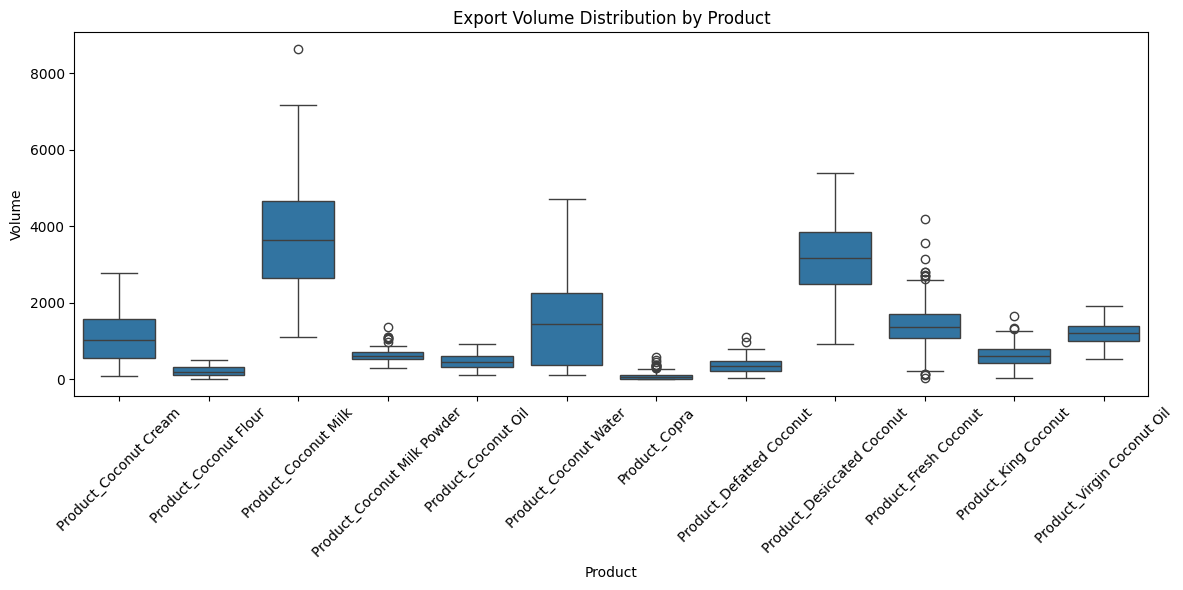

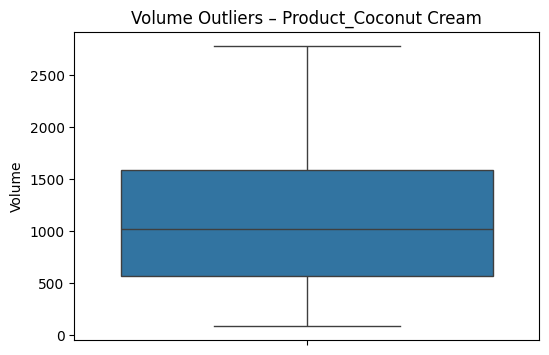

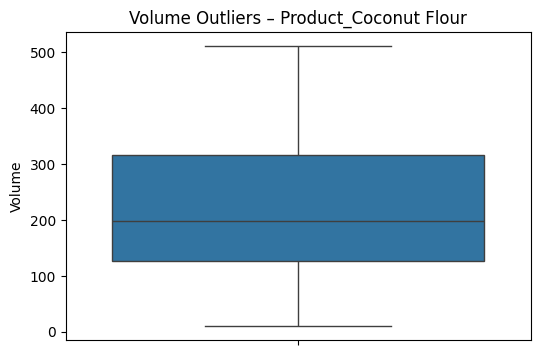

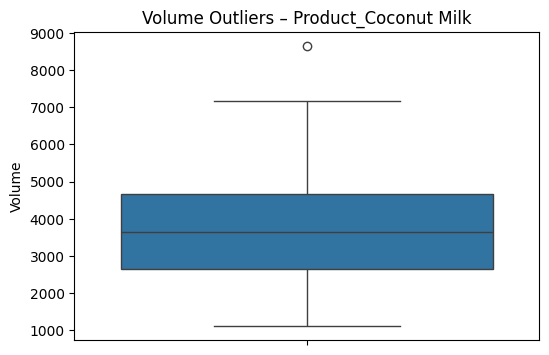

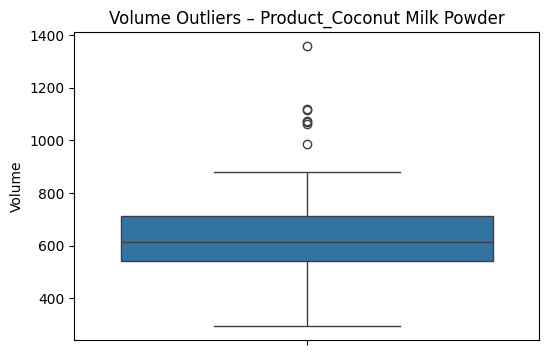

Product       Date  Volume  volume_z
352         Product_Coconut Milk 2024-08-01  8643.0  3.432265
471  Product_Coconut Milk Powder 2024-08-01  1358.0  4.156134
709        Product_Coconut Water 2024-08-01  4725.0  3.090992
772                Product_Copra 2019-12-01   587.0  4.090080
773                Product_Copra 2020-01-01   515.0  3.482716

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df_fe,
    x="Product",
    y="Volume"
)
plt.xticks(rotation=45)
plt.title("Export Volume Distribution by Product")
plt.tight_layout()
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

sample_products = merged_df_fe["Product"].unique()[:4]

for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p]

    plt.figure(figsize=(6, 4))
    sns.boxplot(y=subset["Volume"])
    plt.title(f"Volume Outliers – {p}")
    plt.ylabel("Volume")
    plt.show()

from scipy.stats import zscore

merged_df_fe["volume_z"] = (
    merged_df_fe
    .groupby("Product")["Volume"]
    .transform(lambda x: zscore(x, nan_policy="omit"))
)

# Flag potential outliers
outliers = merged_df_fe[merged_df_fe["volume_z"].abs() > 3]

outliers[["Product", "Date", "Volume", "volume_z"]].head()

# Function to detect IQR outliers for one product


/tmp/ipython-input-1090163973.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: detect_iqr_outliers(x, "Volume"))


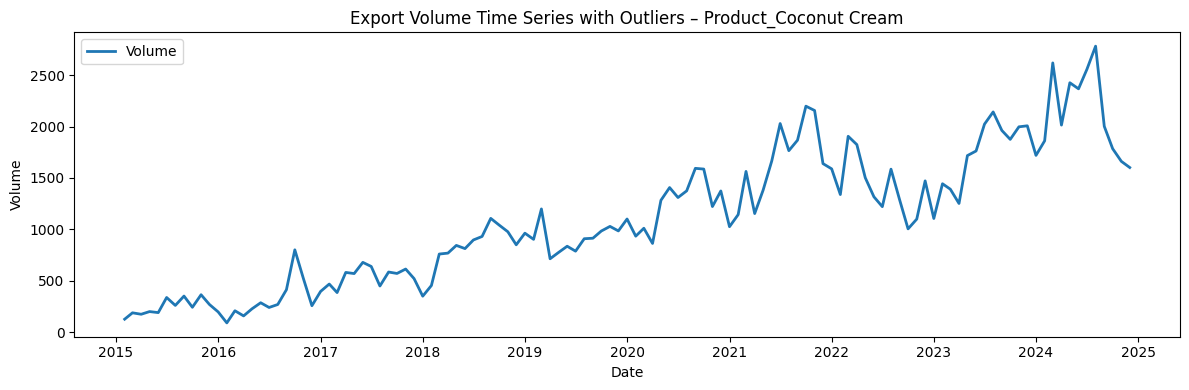

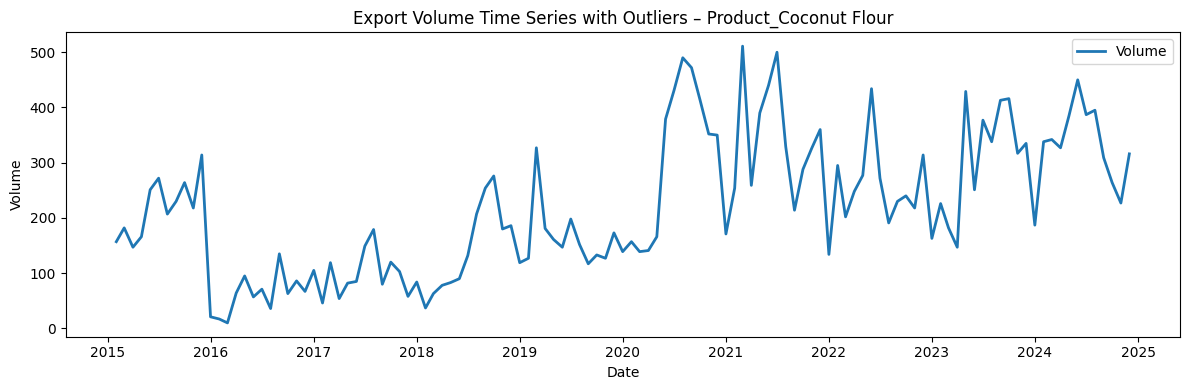

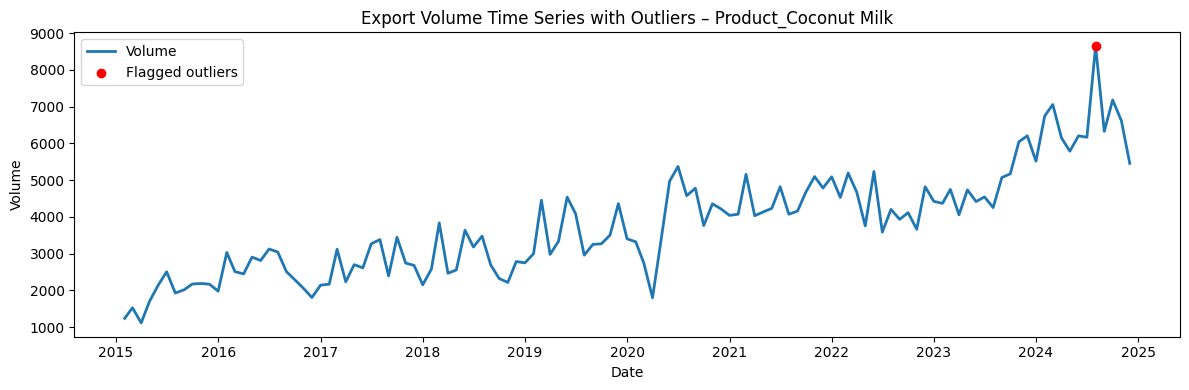

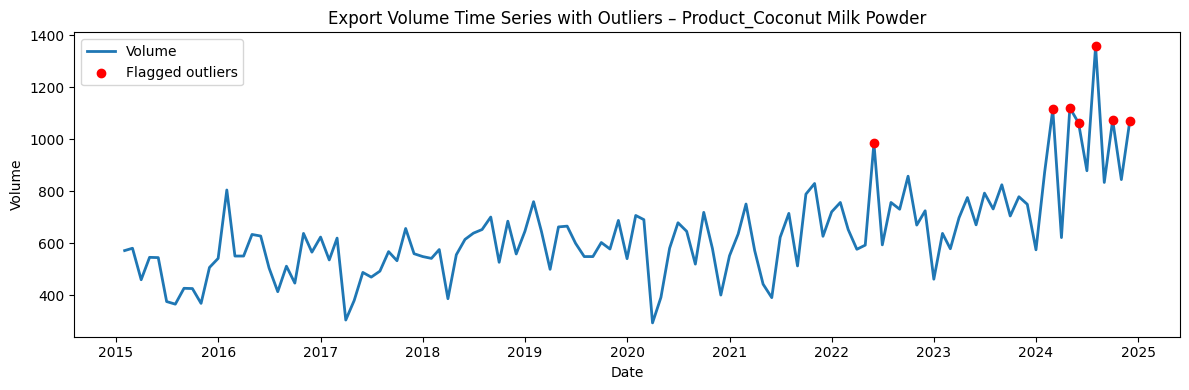

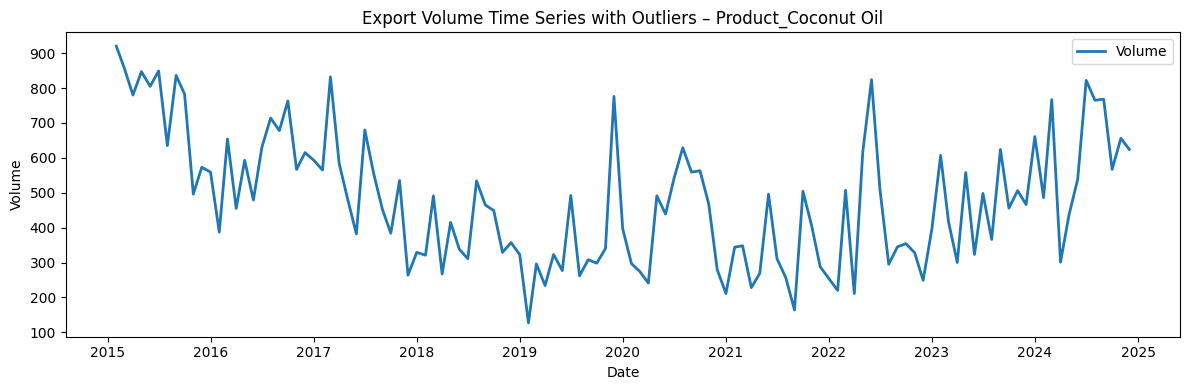

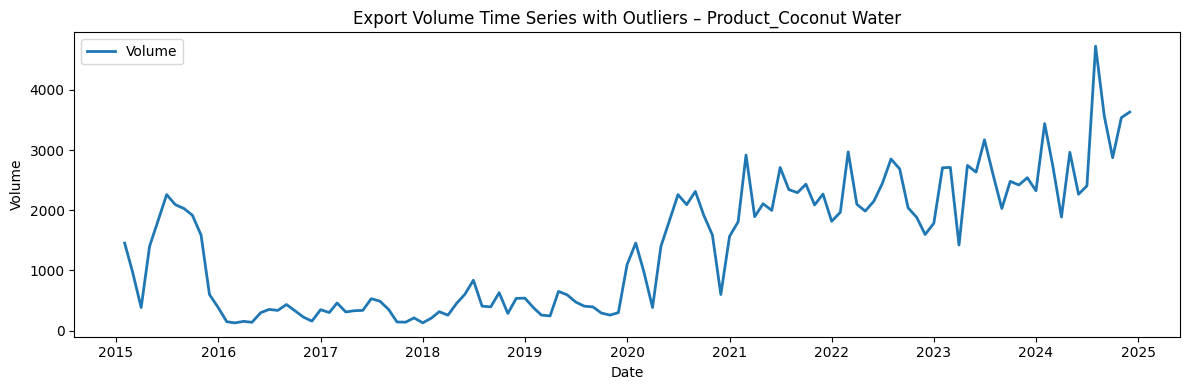

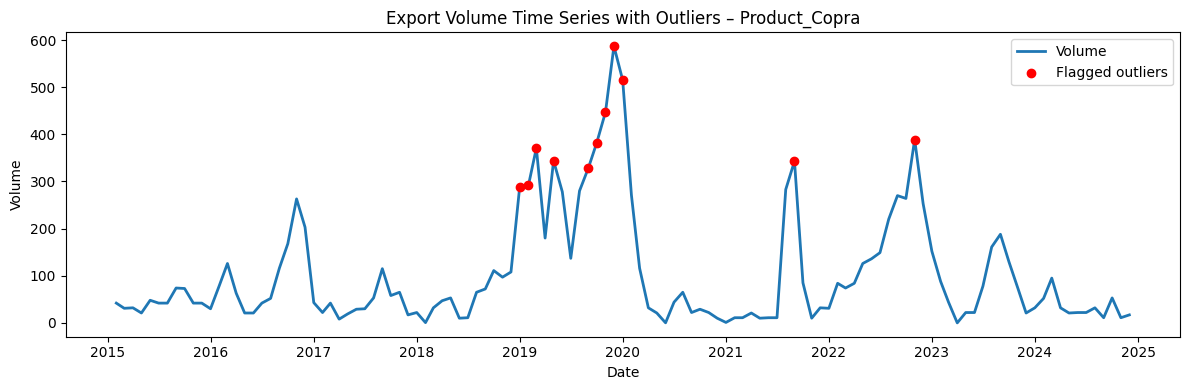

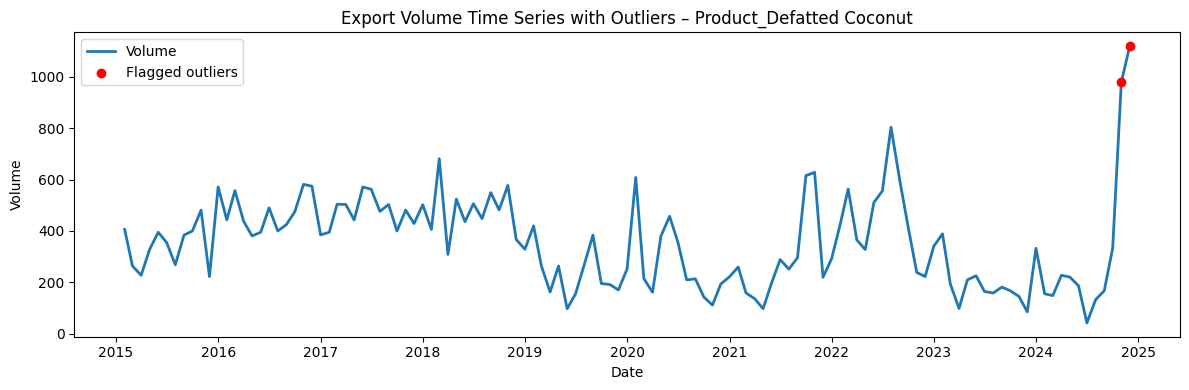

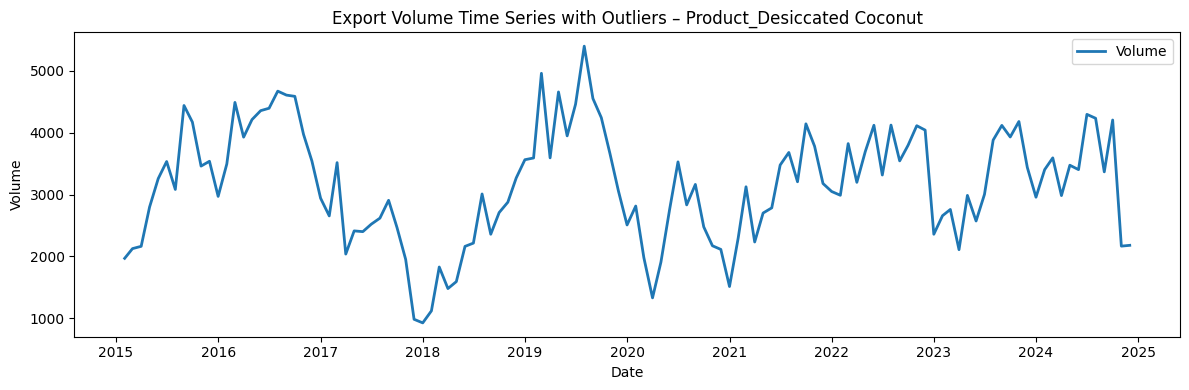

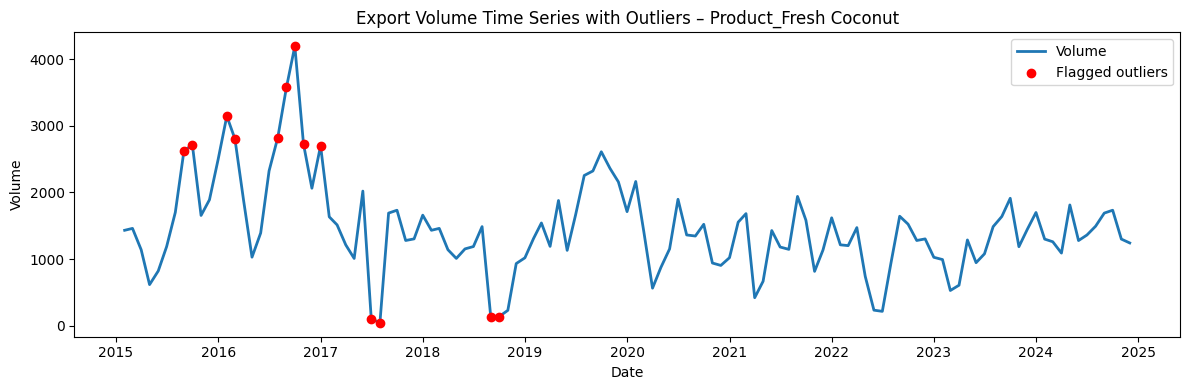

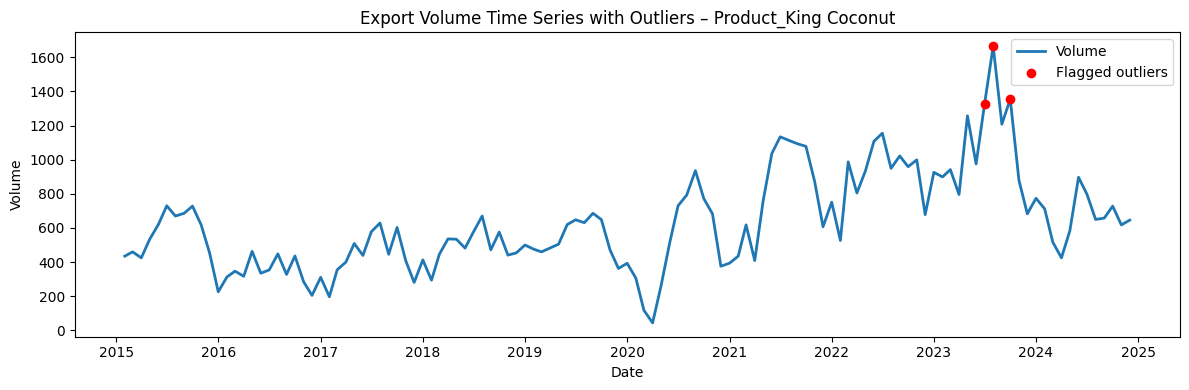

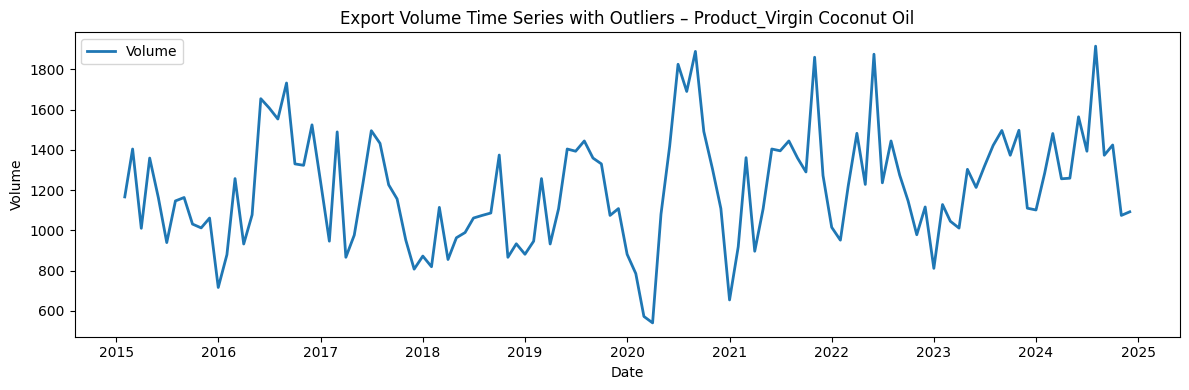

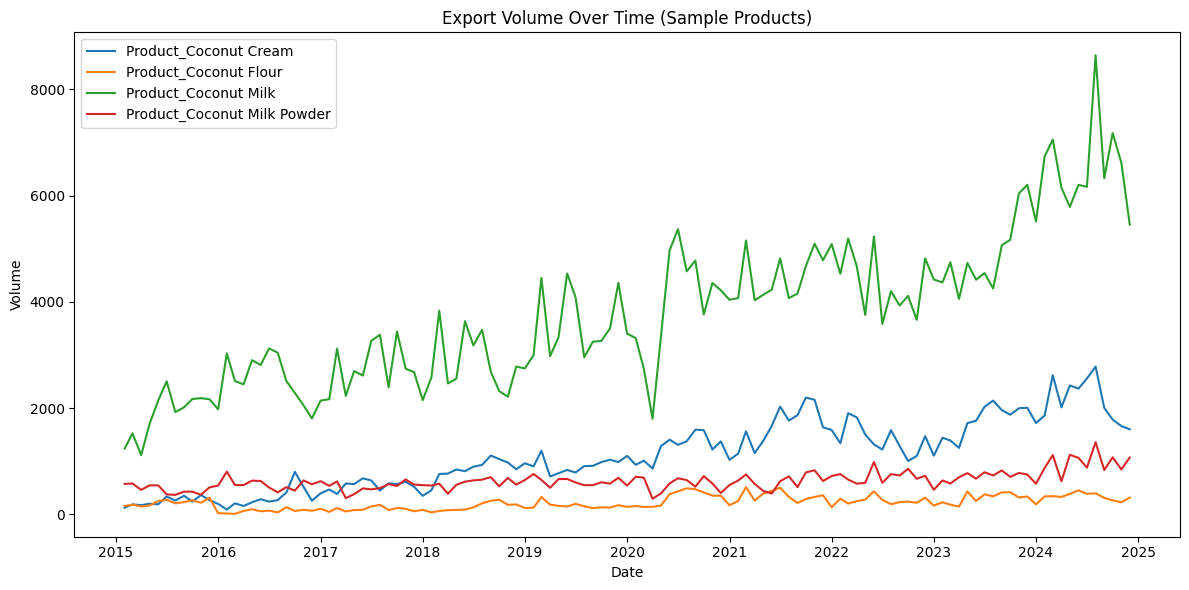

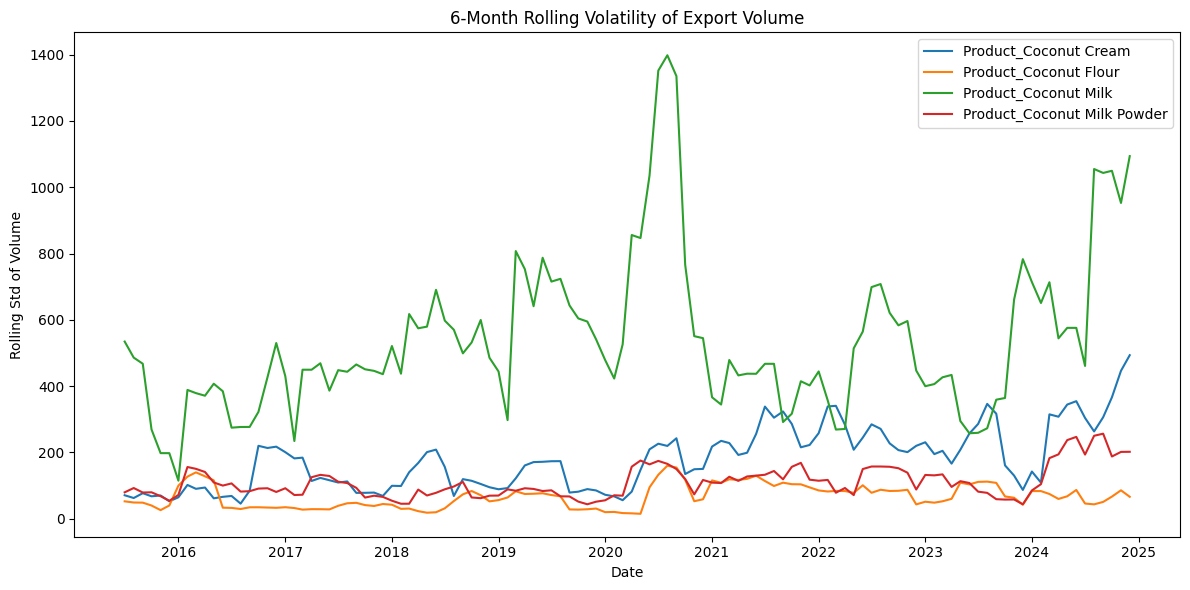

In [10]:
def detect_iqr_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] < lower) | (df[col] > upper)]

# Detect outliers for all products
outliers_df = (
    merged_df_fe
    .groupby("Product", group_keys=False)
    .apply(lambda x: detect_iqr_outliers(x, "Volume"))
)

outliers_df[["Product", "Date", "Volume"]].head()

products = merged_df_fe["Product"].unique()

for p in products:
    subset = merged_df_fe[merged_df_fe["Product"] == p]
    p_outliers = outliers_df[outliers_df["Product"] == p]

    plt.figure(figsize=(12, 4))
    plt.plot(subset["Date"], subset["Volume"], label="Volume", linewidth=2)

    if not p_outliers.empty:
        plt.scatter(
            p_outliers["Date"],
            p_outliers["Volume"],
            color="red",
            label="Flagged outliers",
            zorder=3
        )

    plt.title(f"Export Volume Time Series with Outliers – {p}")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.legend()
    plt.tight_layout()
    plt.show()

sample_products = merged_df_fe["Product"].unique()[:4]

plt.figure(figsize=(12, 6))
for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p]
    plt.plot(subset["Date"], subset["Volume"], label=p)

plt.legend()
plt.title("Export Volume Over Time (Sample Products)")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p].copy()
    subset["rolling_std"] = subset["Volume"].rolling(6).std()
    plt.plot(subset["Date"], subset["rolling_std"], label=p)

plt.legend()
plt.title("6-Month Rolling Volatility of Export Volume")
plt.xlabel("Date")
plt.ylabel("Rolling Std of Volume")
plt.tight_layout()
plt.show()


I decided to keep them because:


*   Covid-19
*   Supply Shocks
*   Policy changes
*   Sudden demand surges

Removing them would hide real-world behaviour

Models like XGBoost can handle such variations

## TEMPORAL TRENDS


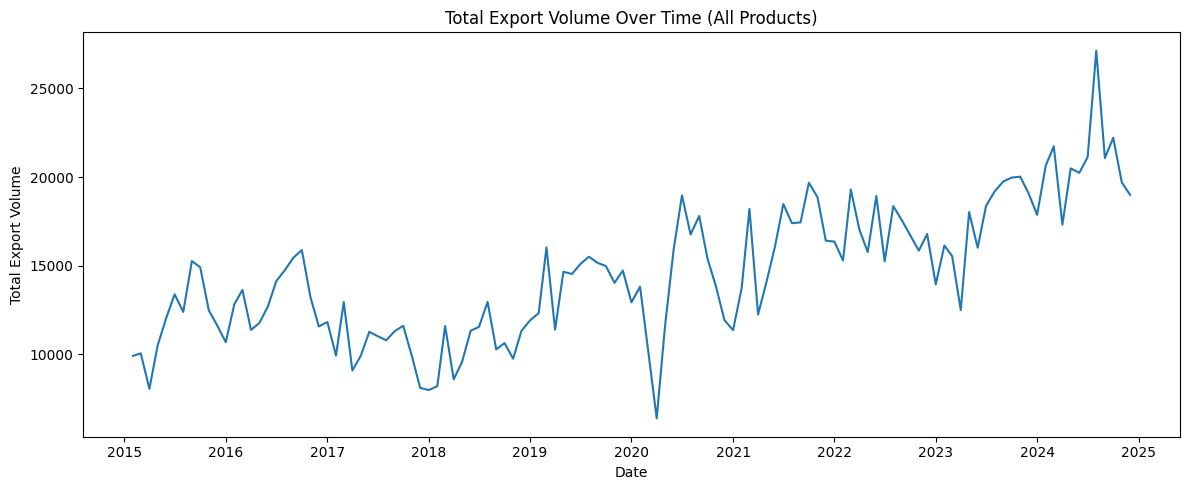

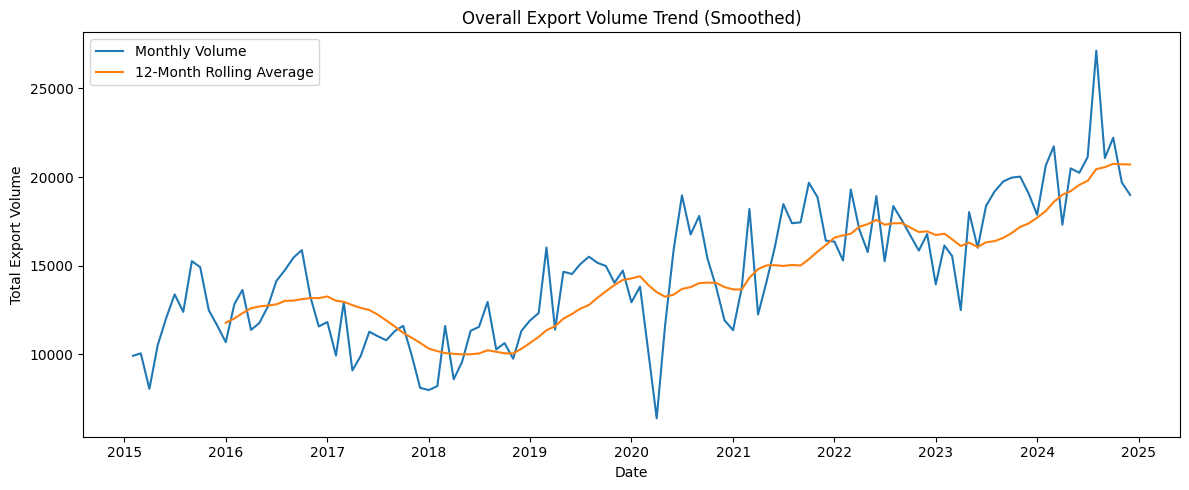

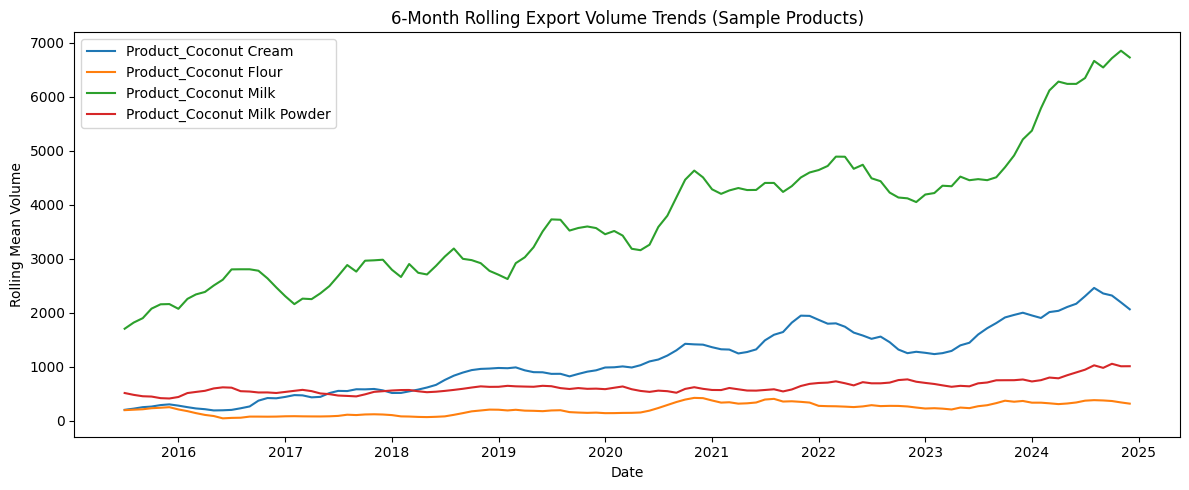

In [11]:

total_volume_ts = (
    merged_df_fe
    .groupby("Date")["Volume"]
    .sum()
)

plt.figure(figsize=(12, 5))
plt.plot(total_volume_ts.index, total_volume_ts.values)
plt.title("Total Export Volume Over Time (All Products)")
plt.xlabel("Date")
plt.ylabel("Total Export Volume")
plt.tight_layout()
plt.show()

rolling_12m = total_volume_ts.rolling(12).mean()

plt.figure(figsize=(12, 5))
plt.plot(total_volume_ts.index, total_volume_ts.values, label="Monthly Volume")
plt.plot(rolling_12m.index, rolling_12m.values, label="12-Month Rolling Average")
plt.title("Overall Export Volume Trend (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Total Export Volume")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p].copy()
    subset["rolling_mean"] = subset["Volume"].rolling(6).mean()
    plt.plot(subset["Date"], subset["rolling_mean"], label=p)

plt.title("6-Month Rolling Export Volume Trends (Sample Products)")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Volume")
plt.legend()
plt.tight_layout()
plt.show()


## Seasonality Analysis


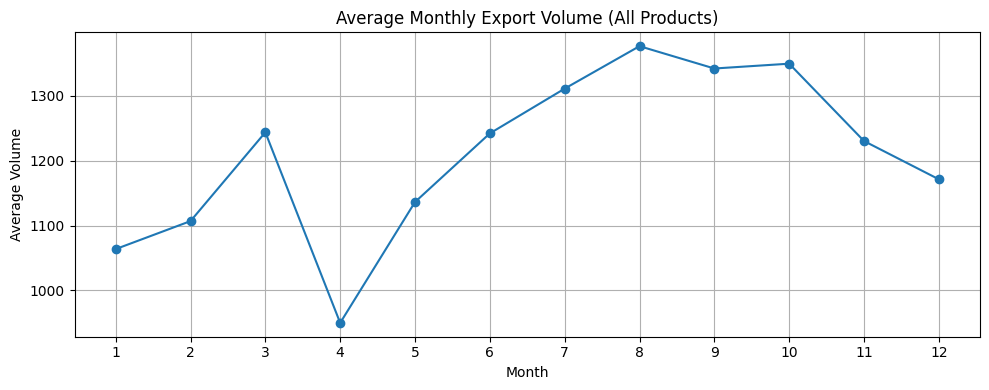

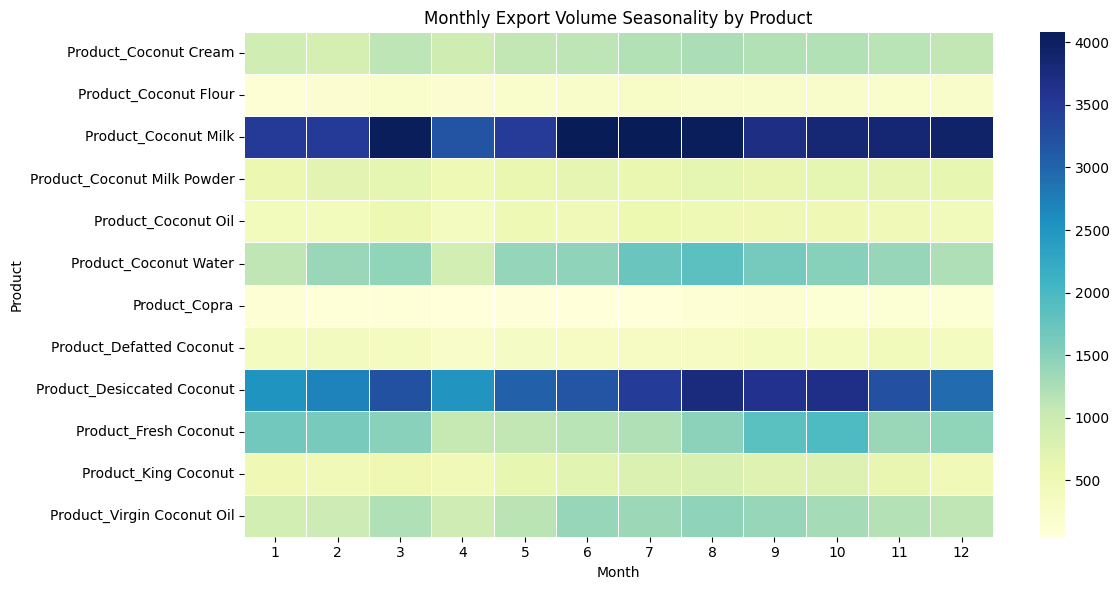

Product
Product_Copra                  1.016353
Product_Coconut Flour          0.702824
Product_Coconut Water          0.652841
Product_Fresh Coconut          0.616363
Product_King Coconut           0.574010
Product_Defatted Coconut       0.502740
Product_Virgin Coconut Oil     0.455835
Product_Coconut Oil            0.426248
Product_Desiccated Coconut     0.394813
Product_Coconut Cream          0.336158
Product_Coconut Milk Powder    0.294349
Product_Coconut Milk           0.235024
Name: Volume, dtype: float64

In [12]:

monthly_avg = (
    merged_df_fe
    .groupby("Month")["Volume"]
    .mean()
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.title("Average Monthly Export Volume (All Products)")
plt.xlabel("Month")
plt.ylabel("Average Volume")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

product_monthly_avg = (
    merged_df_fe
    .groupby(["Product", "Month"])["Volume"]
    .mean()
    .reset_index()
)

product_monthly_avg.head()

pivot_table = product_monthly_avg.pivot(
    index="Product",
    columns="Month",
    values="Volume"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table,
    cmap="YlGnBu",
    linewidths=0.5
)
plt.title("Monthly Export Volume Seasonality by Product")
plt.xlabel("Month")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

seasonality_strength = (
    product_monthly_avg
    .groupby("Product")["Volume"]
    .agg(lambda x: x.max() - x.min())
    .sort_values(ascending=False)
)

seasonality_strength

seasonality_cv = (
    product_monthly_avg
    .groupby("Product")["Volume"]
    .apply(lambda x: (x.max() - x.min()) / x.mean())
    .sort_values(ascending=False)
)

seasonality_cv


## Relationship between Variables


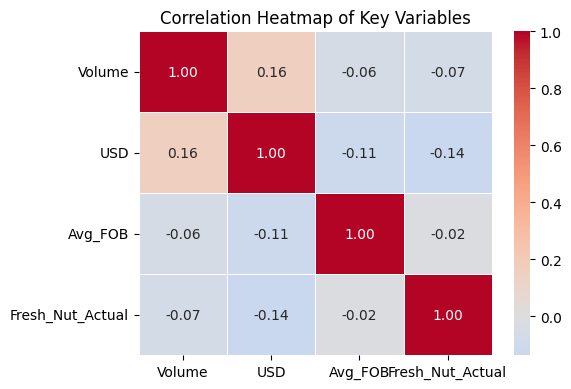

/tmp/ipython-input-405040816.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


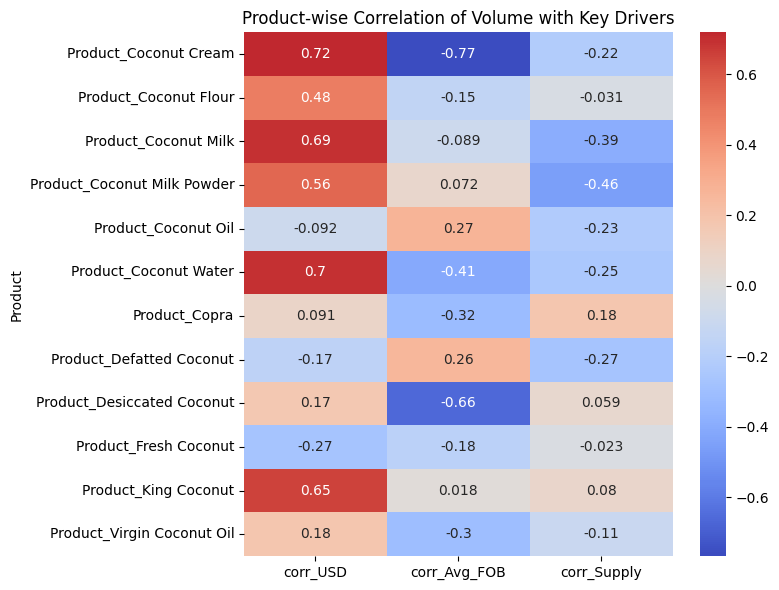

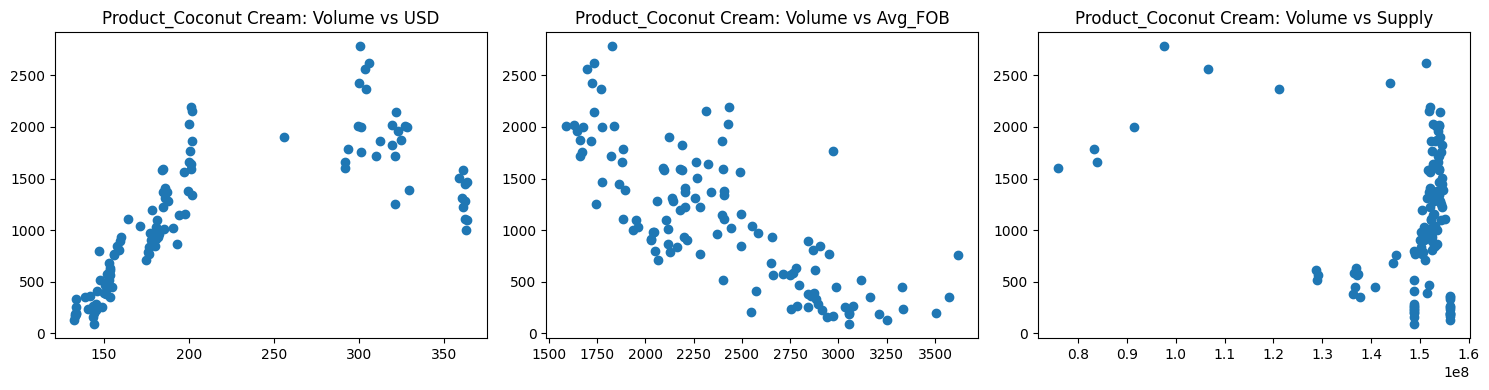

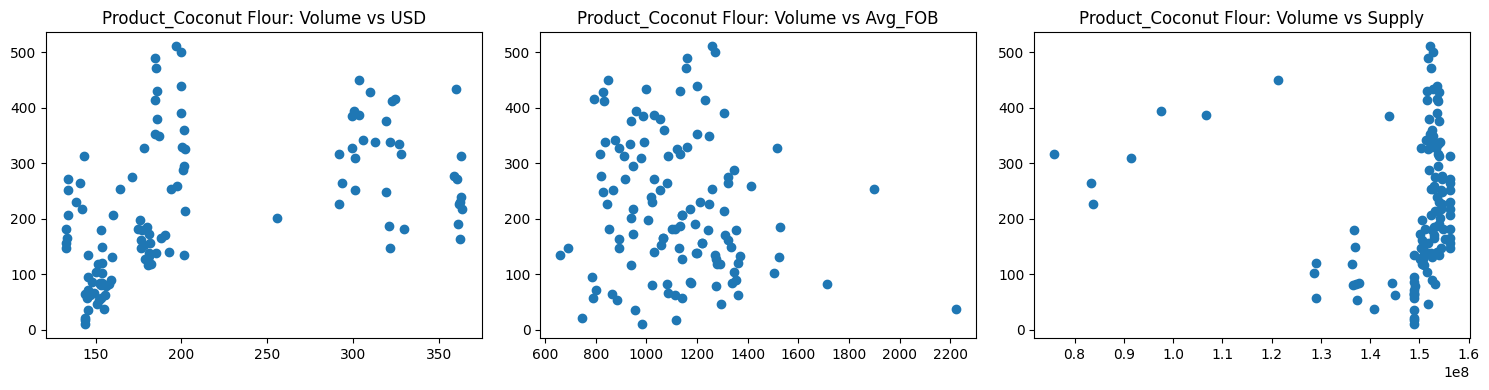

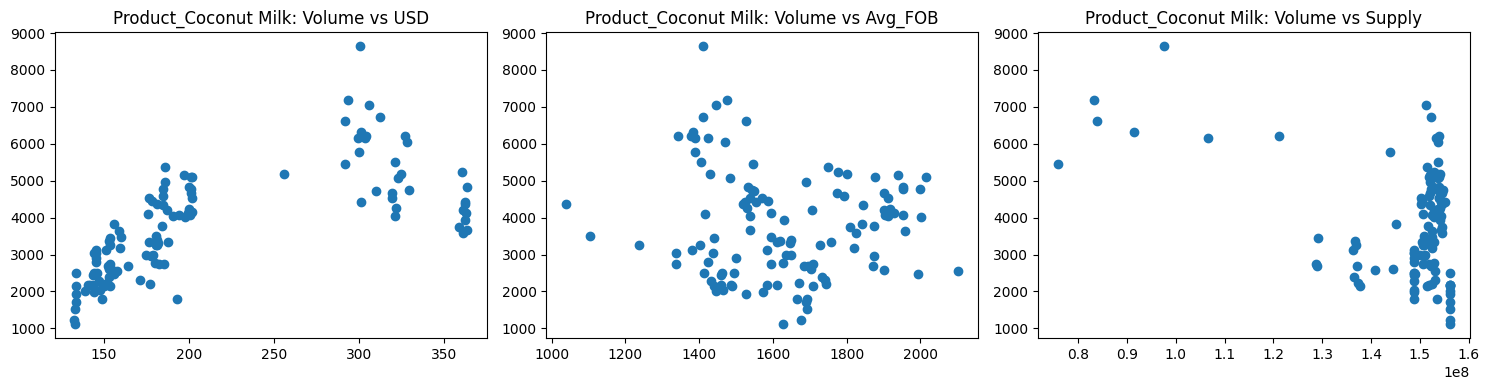

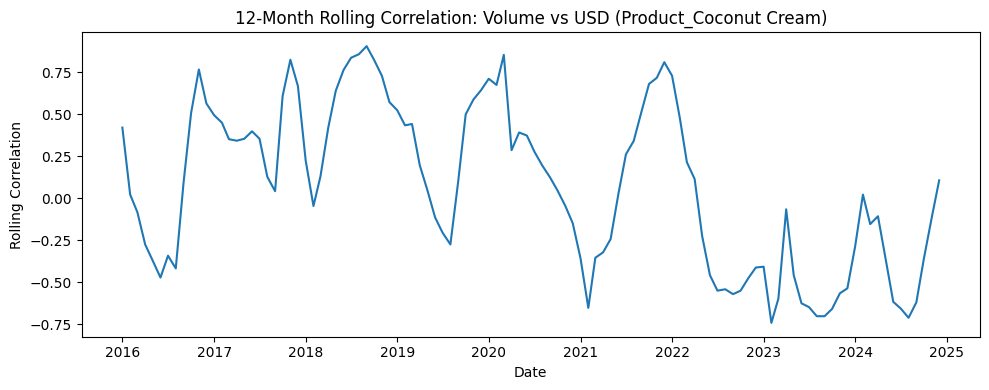

DataFrame successfully saved to /content/drive/MyDrive/Dataset/FYP_Feature_Engineered_Data.csv


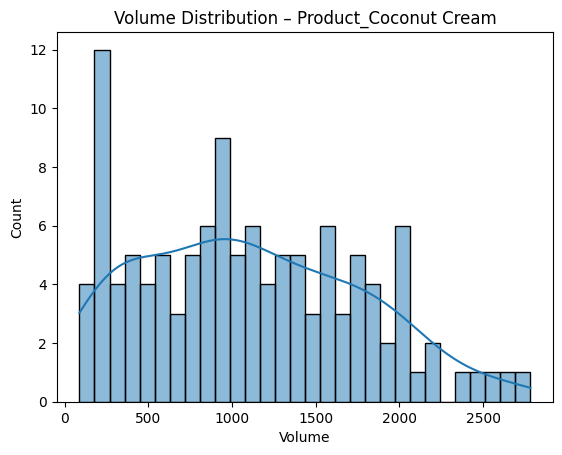

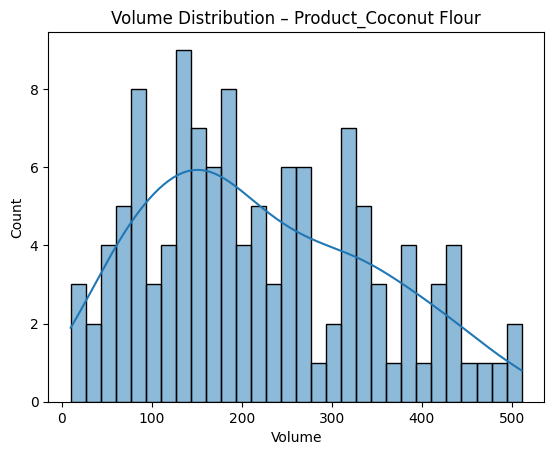

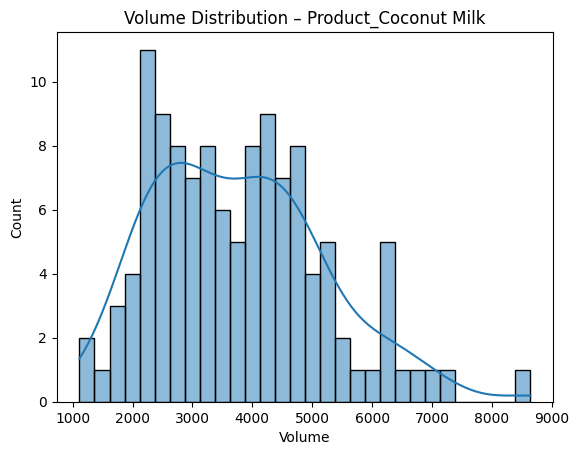

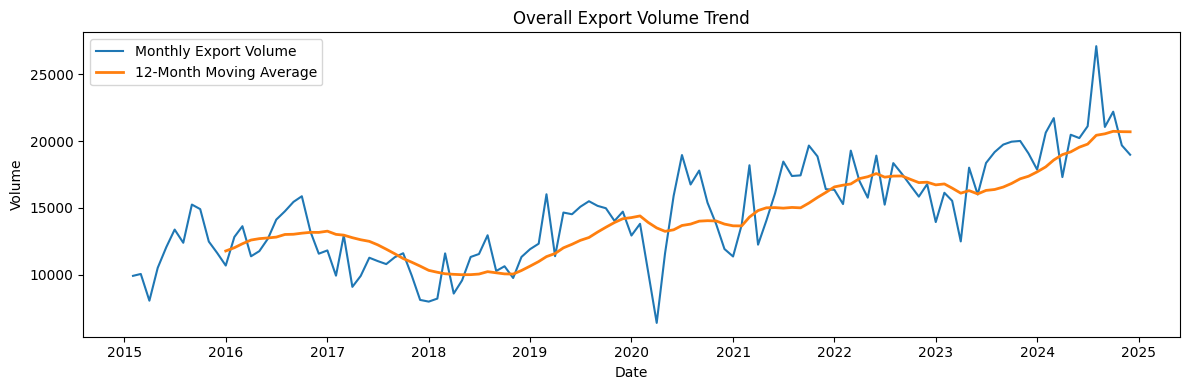

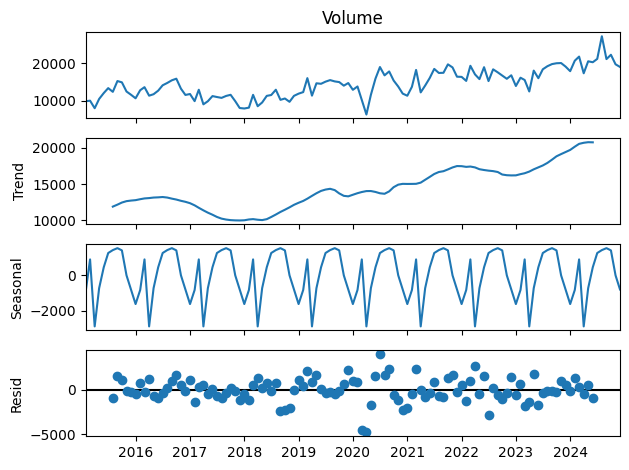

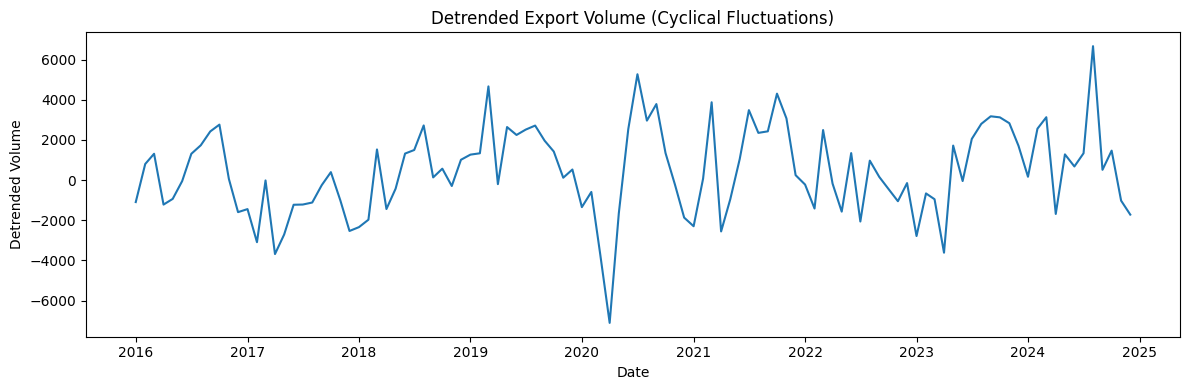

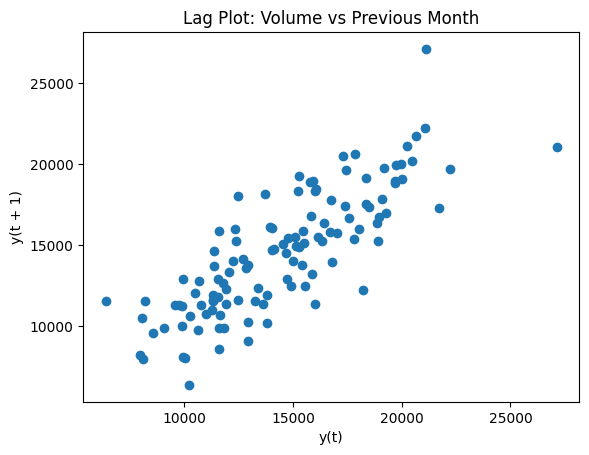

<Figure size 1000x400 with 0 Axes>

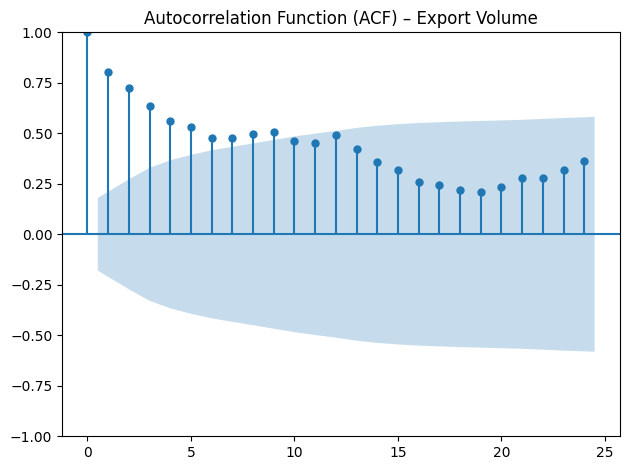

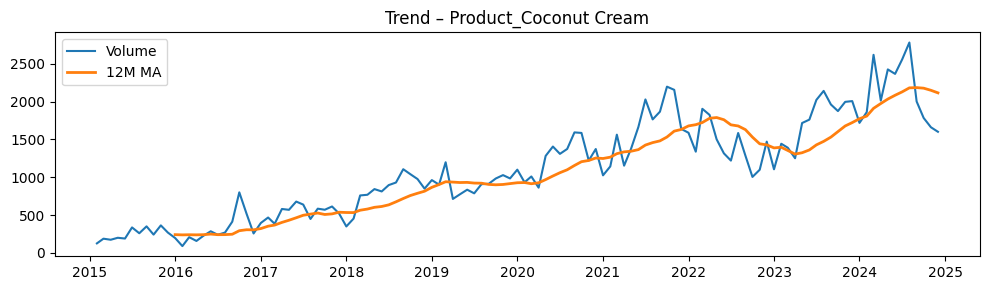

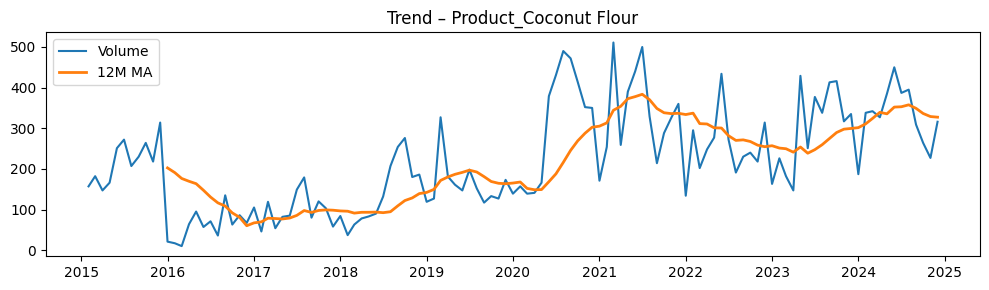

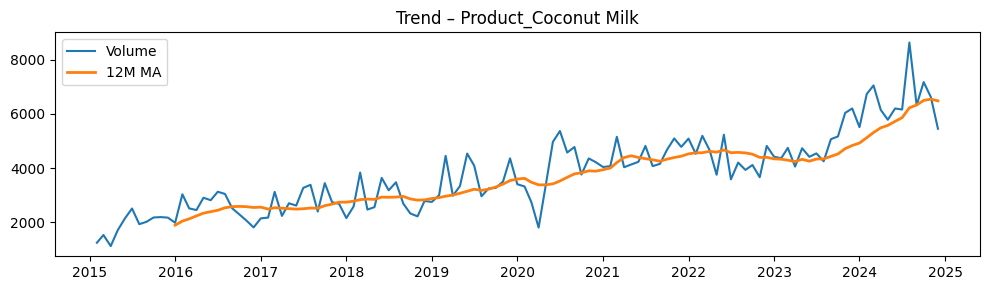

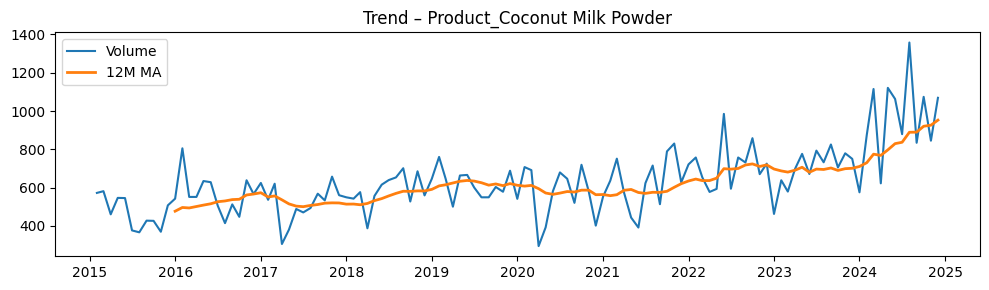

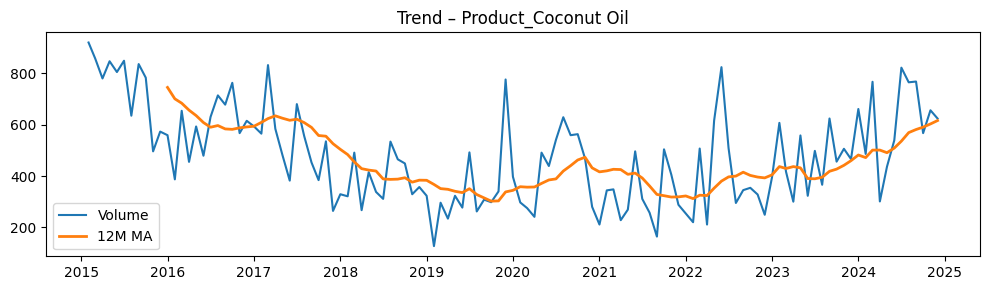

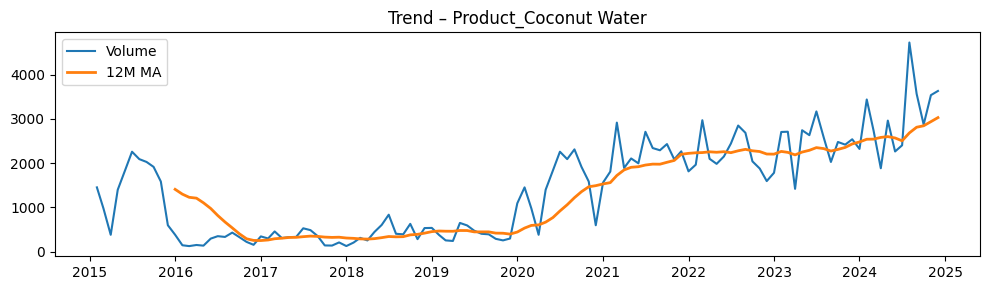

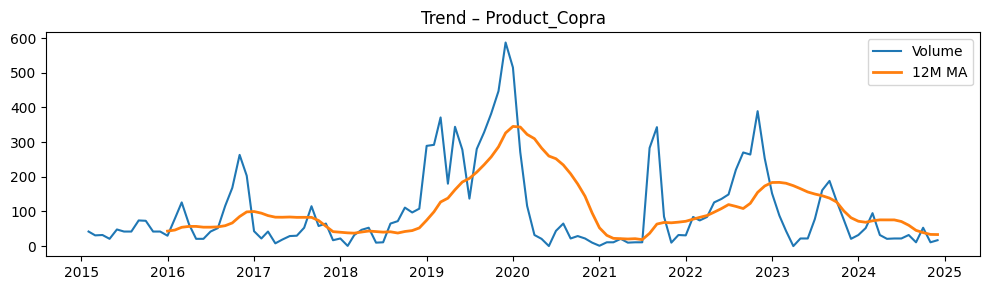

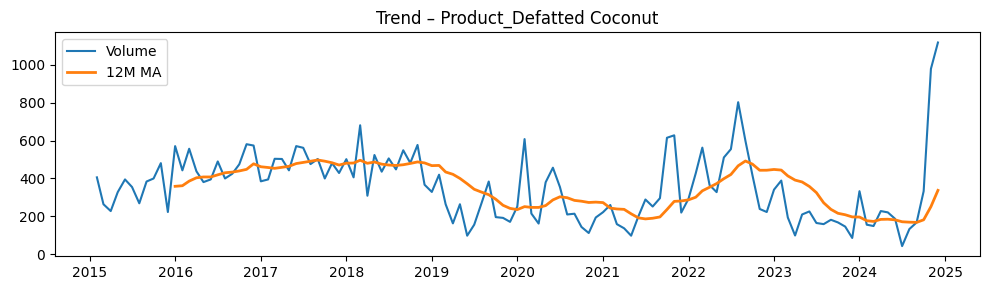

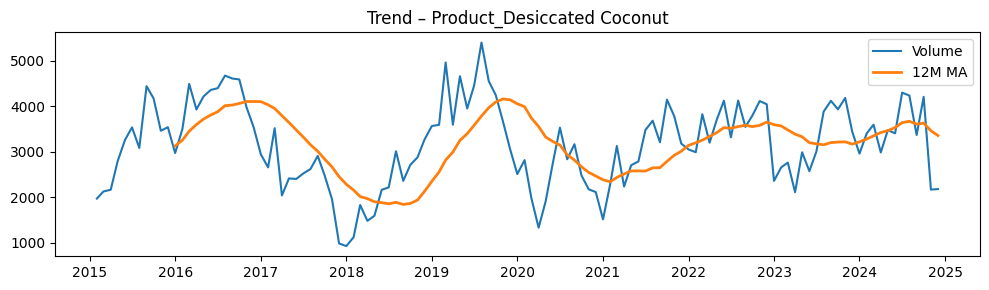

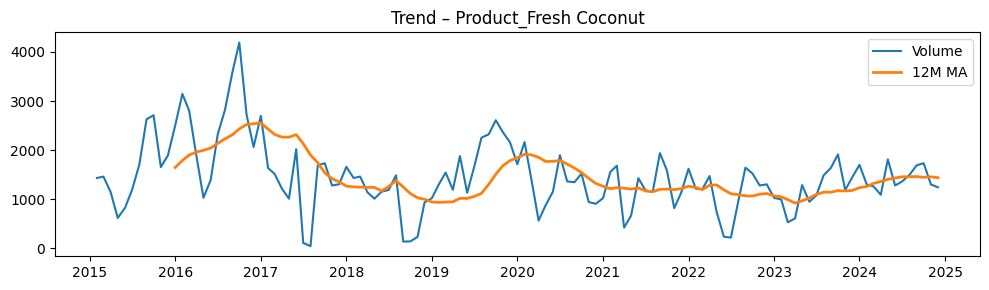

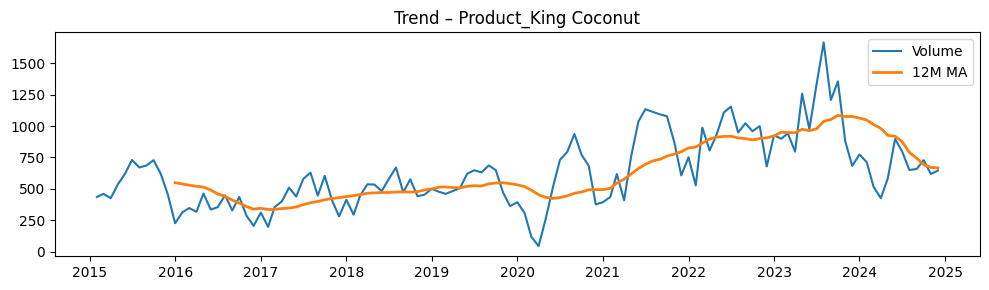

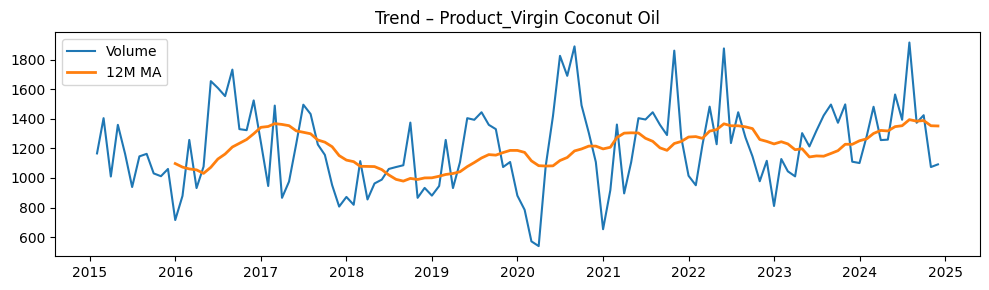

<Figure size 800x300 with 0 Axes>

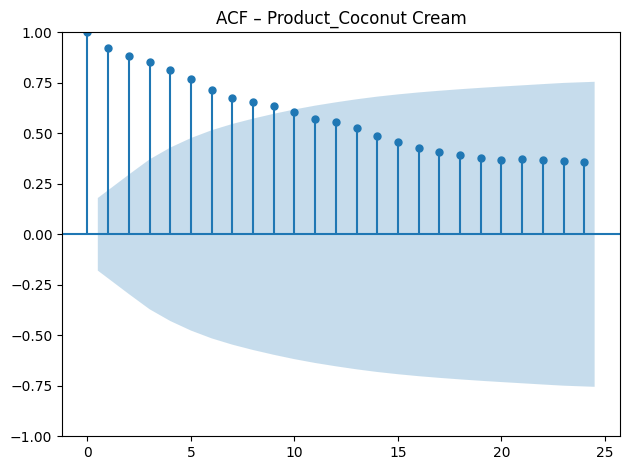

<Figure size 800x300 with 0 Axes>

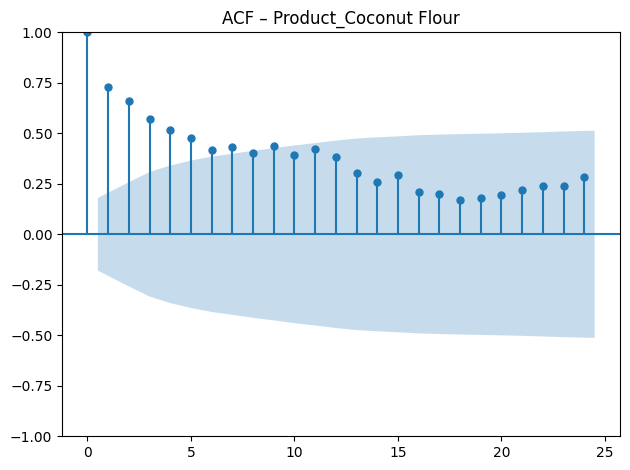

<Figure size 800x300 with 0 Axes>

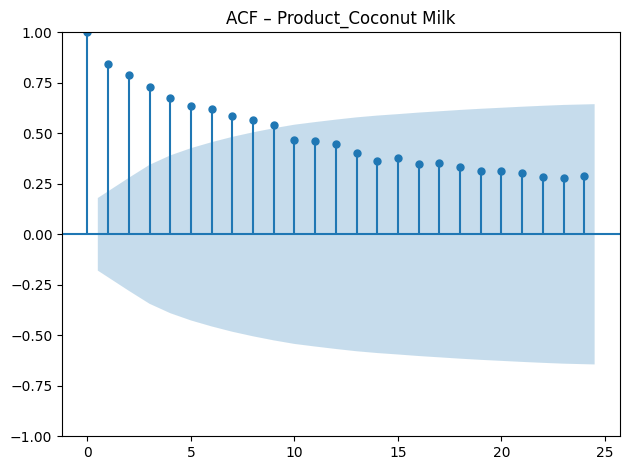

<Figure size 800x300 with 0 Axes>

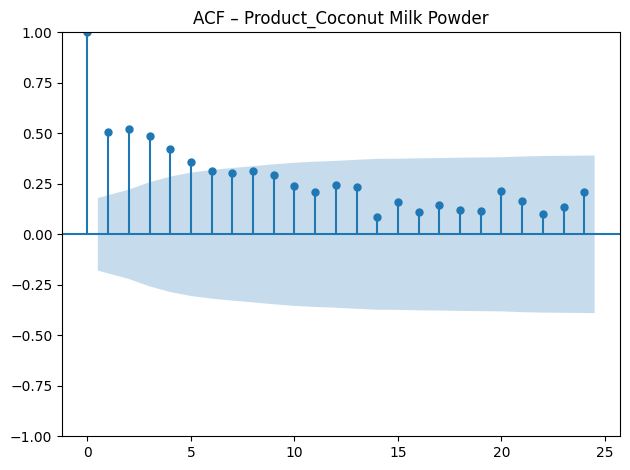

<Figure size 800x300 with 0 Axes>

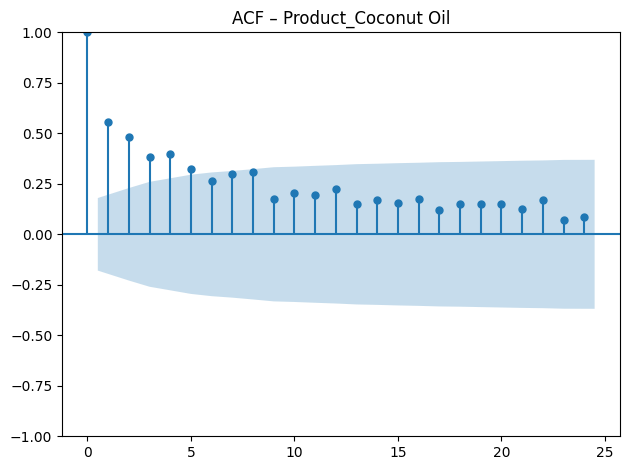

<Figure size 800x300 with 0 Axes>

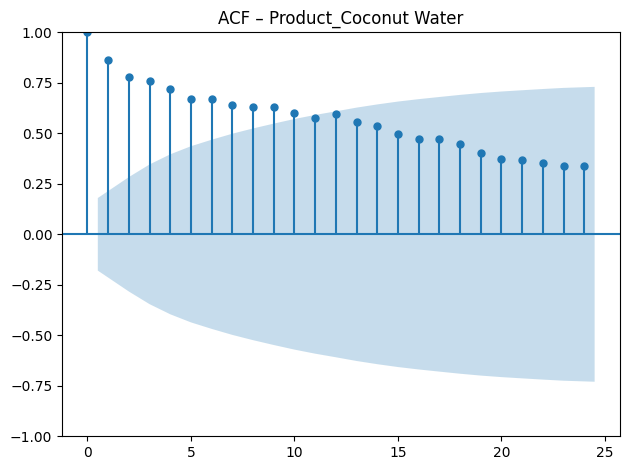

<Figure size 800x300 with 0 Axes>

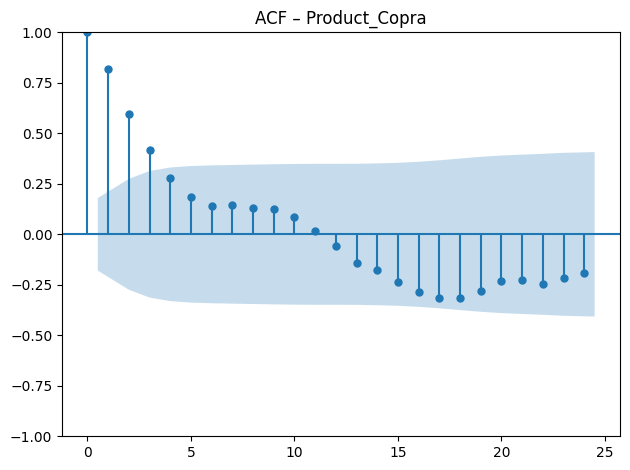

<Figure size 800x300 with 0 Axes>

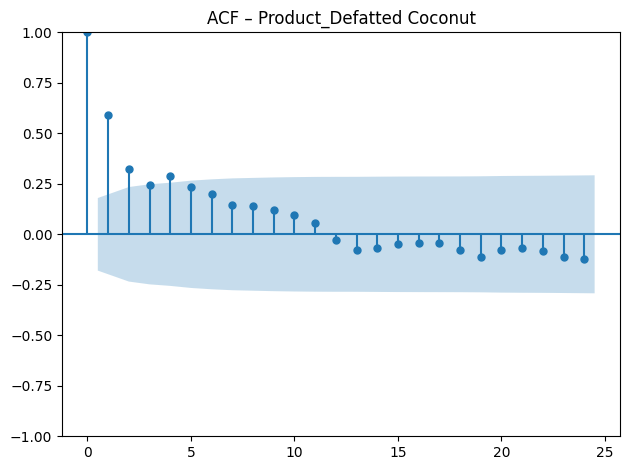

<Figure size 800x300 with 0 Axes>

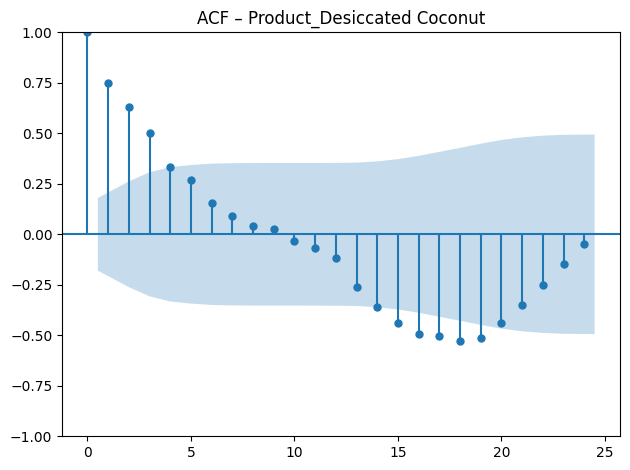

<Figure size 800x300 with 0 Axes>

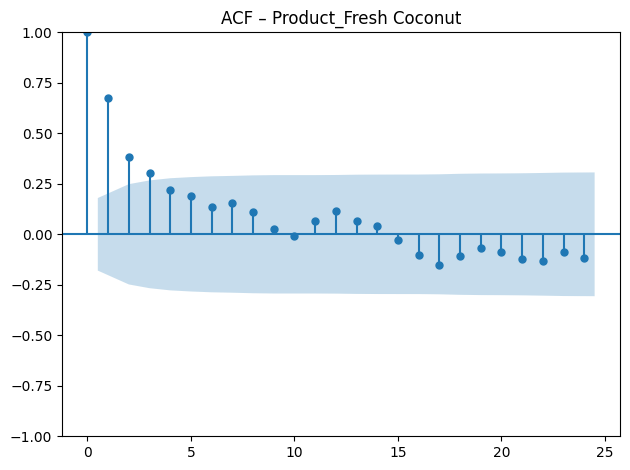

<Figure size 800x300 with 0 Axes>

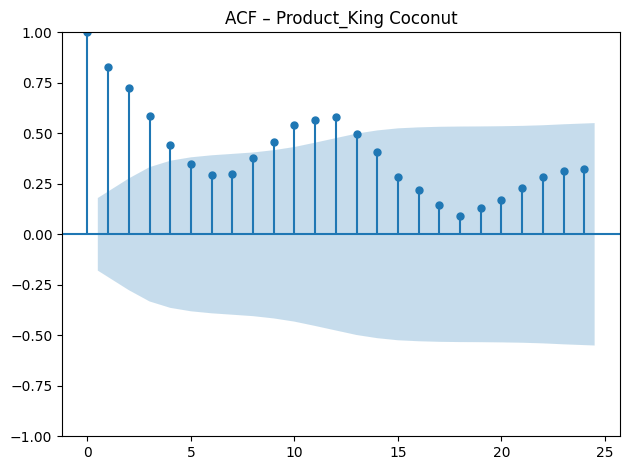

<Figure size 800x300 with 0 Axes>

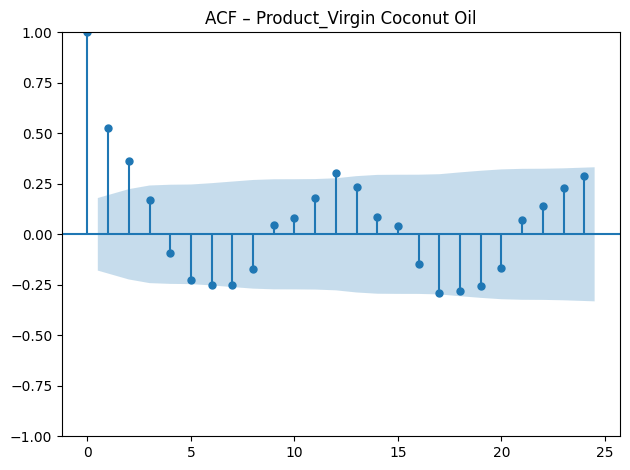

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

overall_corr = merged_df_fe[
    ["Volume", "USD", "Avg_FOB", "Fresh_Nut_Actual"]
].corr()

overall_corr

plt.figure(figsize=(6, 4))

sns.heatmap(
    overall_corr,
    annot=True,          # show correlation values
    fmt=".2f",           # 2 decimal places
    cmap="coolwarm",     # red–blue colour scale
    center=0,            # zero-centered colour
    linewidths=0.5
)

plt.title("Correlation Heatmap of Key Variables")
plt.tight_layout()
plt.show()

product_corr = (
    merged_df_fe
    .groupby("Product")
    .apply(lambda x: pd.Series({
        "corr_USD": x["Volume"].corr(x["USD"]),
        "corr_Avg_FOB": x["Volume"].corr(x["Avg_FOB"]),
        "corr_Supply": x["Volume"].corr(x["Fresh_Nut_Actual"])
    }))
)

product_corr

plt.figure(figsize=(8, 6))
sns.heatmap(
    product_corr,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Product-wise Correlation of Volume with Key Drivers")
plt.tight_layout()
plt.show()

sample_products = merged_df_fe["Product"].unique()[:3]

for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].scatter(subset["USD"], subset["Volume"])
    axes[0].set_title(f"{p}: Volume vs USD")

    axes[1].scatter(subset["Avg_FOB"], subset["Volume"])
    axes[1].set_title(f"{p}: Volume vs Avg_FOB")

    axes[2].scatter(subset["Fresh_Nut_Actual"], subset["Volume"])
    axes[2].set_title(f"{p}: Volume vs Supply")

    plt.tight_layout()
    plt.show()

p = merged_df_fe["Product"].unique()[0]
subset = merged_df_fe[merged_df_fe["Product"] == p].copy()

subset["rolling_corr_usd"] = (
    subset["Volume"]
    .rolling(12)
    .corr(subset["USD"])
)

plt.figure(figsize=(10, 4))
plt.plot(subset["Date"], subset["rolling_corr_usd"])
plt.title(f"12-Month Rolling Correlation: Volume vs USD ({p})")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation")
plt.tight_layout()
plt.show()

output_path_fe = '/content/drive/MyDrive/Dataset/FYP_Feature_Engineered_Data.csv'
merged_df_fe.to_csv(output_path_fe, index=False)
print(f"DataFrame successfully saved to {output_path_fe}")

# volume distribution -
merged_df_fe.groupby("Product")["Volume"].skew().sort_values(ascending=False)
sample_products = merged_df_fe["Product"].unique()[:3]

for p in sample_products:
    subset = merged_df_fe[merged_df_fe["Product"] == p]
    sns.histplot(subset["Volume"], bins=30, kde=True)
    plt.title(f"Volume Distribution – {p}")
    plt.show()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Aggregate total export volume per month
ts_total = (
    merged_df_fe
    .groupby("Date")["Volume"]
    .sum()
    .sort_index()
)

# orange line shows the long term direction --> exportts increaseing with time
plt.figure(figsize=(12, 4))
plt.plot(ts_total, label="Monthly Export Volume")
plt.plot(ts_total.rolling(12).mean(), label="12-Month Moving Average", linewidth=2)
plt.title("Overall Export Volume Trend")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()
plt.show()

# Volume - raw export data
# trend - underlying long term movement
# seasonal - repeating patterns every year
# residual - after removing trends and seasonality
decomp = seasonal_decompose(ts_total, model="additive", period=12)

decomp.plot()
plt.tight_layout()
plt.show()

# Remove trend using rolling mean --> removing long term trend
trend = ts_total.rolling(12).mean()
detrended = ts_total - trend

plt.figure(figsize=(12, 4))
plt.plot(detrended)
plt.title("Detrended Export Volume (Cyclical Fluctuations)")
plt.xlabel("Date")
plt.ylabel("Detrended Volume")
plt.tight_layout()
plt.show()

# export volumes are predictable from last month
pd.plotting.lag_plot(ts_total)
plt.title("Lag Plot: Volume vs Previous Month")
plt.show()

# todays export depending on previous months exports
plt.figure(figsize=(10, 4))
plot_acf(ts_total, lags=24)
plt.title("Autocorrelation Function (ACF) – Export Volume")
plt.tight_layout()
plt.show()
# each bar - correlation with past month
# slowly decreasing correlation over time

for p in merged_df_fe["Product"].unique():
    ts = (
        merged_df_fe[merged_df_fe["Product"] == p]
        .set_index("Date")["Volume"]
        .sort_index()
    )

    plt.figure(figsize=(10, 3))
    plt.plot(ts, label="Volume")
    plt.plot(ts.rolling(12).mean(), linewidth=2, label="12M MA")
    plt.title(f"Trend – {p}")
    plt.legend()
    plt.tight_layout()
    plt.show()

from statsmodels.graphics.tsaplots import plot_acf

for p in merged_df_fe["Product"].unique():
    ts = (
        merged_df_fe[merged_df_fe["Product"] == p]
        .set_index("Date")["Volume"]
        .sort_index()
    )

    plt.figure(figsize=(8, 3))
    plot_acf(ts, lags=24)
    plt.title(f"ACF – {p}")
    plt.tight_layout()
    plt.show()


# Clustering


In [14]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# ---------- Safety: Date, Product ----------
merged_df_fe["Date"] = pd.to_datetime(merged_df_fe["Date"])

product_cols = [c for c in merged_df_fe.columns if c.startswith("Product_")]
merged_df_fe["Product"] = (
    merged_df_fe[product_cols]
    .idxmax(axis=1)
    .str.replace("Product_", "")
)

merged_df_fe = merged_df_fe.sort_values(["Product", "Date"]).reset_index(drop=True)
merged_df_fe["Month"] = merged_df_fe["Date"].dt.month

from sklearn.linear_model import LinearRegression

# --- 1) Relative volatility (CV) ---
vol_stats = merged_df_fe.groupby("Product")["Volume"].agg(["mean", "std"])
vol_stats["vol_cv"] = vol_stats["std"] / vol_stats["mean"]

# --- 2) Seasonality strength (unit-safe) ---
merged_df_fe["Month"] = merged_df_fe["Date"].dt.month

product_monthly_avg = (
    merged_df_fe.groupby(["Product", "Month"])["Volume"]
    .mean()
    .reset_index()
)

seasonality_cv = (
    product_monthly_avg
    .groupby("Product")["Volume"]
    .apply(lambda x: (x.max() - x.min()) / x.mean())
)

# --- 3) Driver sensitivities (correlations) ---
product_corr = (
    merged_df_fe
    .groupby("Product")
    .apply(lambda x: pd.Series({
        "corr_USD": x["Volume"].corr(x["USD"]),
        "corr_Avg_FOB": x["Volume"].corr(x["Avg_FOB"]),
        "corr_Supply": x["Volume"].corr(x["Fresh_Nut_Actual"])
    }))
)

# --- 4) Normalized trend strength ---


/tmp/ipython-input-3277008791.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


In [15]:
def normalized_trend_strength(df):
    df = df.sort_values("Date")
    t = np.arange(len(df)).reshape(-1, 1)
    y = df["Volume"].values
    if len(y) < 5 or np.isnan(y).all():
        return np.nan
    model = LinearRegression()
    model.fit(t, y)
    slope = model.coef_[0]
    mean_vol = np.mean(y)
    return np.abs(slope) / mean_vol if mean_vol != 0 else np.nan

trend_strength = (
    merged_df_fe.groupby("Product")
    .apply(normalized_trend_strength)
    .rename("trend_strength")
)

# --- Combine into cluster_df ---
cluster_df = pd.concat([
    vol_stats[["vol_cv"]],
    seasonality_cv.rename("seasonality_cv"),
    product_corr,
    trend_strength
], axis=1).reset_index()

cluster_df

# Features for clustering
feature_cols = ["vol_cv", "seasonality_cv", "corr_USD", "corr_Avg_FOB", "corr_Supply", "trend_strength"]

# Clean + scale
cluster_df_clean = cluster_df.dropna(subset=feature_cols).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df_clean[feature_cols])

cluster_df_clean

cluster_df_clean[["trend_strength"]].describe()


/tmp/ipython-input-2268701994.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(normalized_trend_strength)


trend_strength
count       12.000000
mean         0.006558
std          0.005381
min          0.000600
25%          0.002566
50%          0.004549
75%          0.009690
max          0.016300

In [16]:
def trend_growth_rate(ts):
    ts = ts.dropna()
    if len(ts) < 24:
        return np.nan
    start = ts.iloc[:12].mean()
    end = ts.iloc[-12:].mean()
    return (end - start) / start

trend_growth = (
    merged_df_fe
    .groupby("Product")["Volume"]
    .apply(trend_growth_rate)
    .reset_index(name="trend_growth_rate")
)

print(trend_growth)


                Product  trend_growth_rate
0         Coconut Cream           7.798683
1         Coconut Flour           0.616715
2          Coconut Milk           2.433758
3   Coconut Milk Powder           0.999125
4           Coconut Oil          -0.173247
5         Coconut Water           1.148862
6                 Copra          -0.229287
7      Defatted Coconut          -0.059480
8    Desiccated Coconut           0.073219
9         Fresh Coconut          -0.125855
10         King Coconut           0.215761
11   Virgin Coconut Oil           0.231377


Elbow Methods


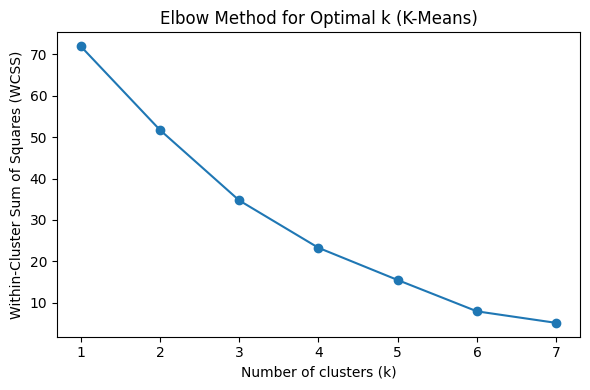

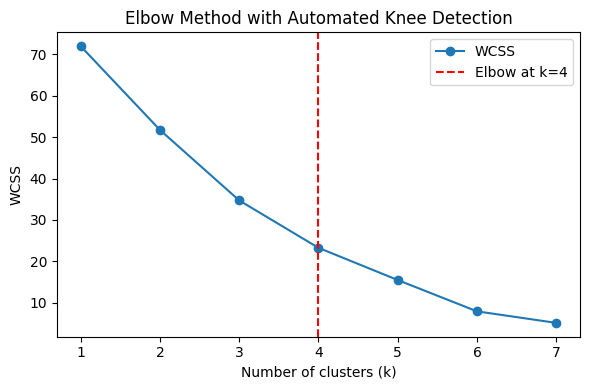

In [17]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []

K_range = range(1, 8)  # 1 to 7 clusters (enough for 12 products)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia = WCSS

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k (K-Means)")
plt.tight_layout()
plt.show()

!pip install kneed

from kneed import KneeLocator

kl = KneeLocator(
    list(K_range),
    wcss,
    curve="convex",
    direction="decreasing"
)

elbow_k = kl.elbow
elbow_k

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker="o", label="WCSS")
plt.axvline(elbow_k, color="red", linestyle="--", label=f"Elbow at k={elbow_k}")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method with Automated Knee Detection")
plt.legend()
plt.tight_layout()
plt.show()


## K-Means


In [19]:

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# -------------------------
# 1) KMEANS (k = 2..6)
# -------------------------
kmeans_results = []
for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    kmeans_results.append({
        "method": "KMeans",
        "k": k,
        "silhouette": silhouette_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels)
    })
kmeans_results = pd.DataFrame(kmeans_results)


## Hierachical Clustering


In [20]:

hier_results = []
for k in range(2, 7):
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(X_scaled)
    hier_results.append({
        "method": "Hierarchical",
        "k": k,
        "silhouette": silhouette_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels)
    })
hier_results = pd.DataFrame(hier_results)


## Gaussian Mixture


In [21]:

gmm_results = []
for k in range(2, 7):
    model = GaussianMixture(n_components=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    gmm_results.append({
        "method": "GMM",
        "k": k,
        "silhouette": silhouette_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
        "bic": model.bic(X_scaled),
        "aic": model.aic(X_scaled)
    })
gmm_results = pd.DataFrame(gmm_results)


## Db Scan


In [22]:

dbscan_results = []
for eps in [0.8, 1.0, 1.2, 1.4, 1.6]:
    model = DBSCAN(eps=eps, min_samples=2)
    labels = model.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    row = {"method": "DBSCAN", "eps": eps, "clusters": n_clusters, "noise_points": int((labels == -1).sum())}

    # score only if DBSCAN produced >=2 clusters and not all noise
    if n_clusters >= 2 and (labels != -1).sum() > 0:
        mask = labels != -1
        row.update({
            "silhouette": silhouette_score(X_scaled[mask], labels[mask]),
            "davies_bouldin": davies_bouldin_score(X_scaled[mask], labels[mask]),
            "calinski_harabasz": calinski_harabasz_score(X_scaled[mask], labels[mask])
        })
    dbscan_results.append(row)

dbscan_results = pd.DataFrame(dbscan_results)


Silhouette Score - highest value
Davies Bouldign - Lowest values
Calinski - Highest score


In [23]:
all_results = pd.concat(
    [kmeans_results, hier_results, gmm_results],
    ignore_index=True
).sort_values(["silhouette"], ascending=False)

print("=== Top results (KMeans/Hierarchical/GMM) by Silhouette ===")
display(all_results.head(10))

print("\n=== DBSCAN results (various eps) ===")
display(dbscan_results.sort_values(["clusters", "noise_points"], ascending=[False, True]).head(10))

best_k = int(kmeans_results.sort_values("silhouette", ascending=False).iloc[0]["k"])

final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_df_clean["cluster_kmeans"] = final_kmeans.fit_predict(X_scaled)

cluster_df_clean[["Product", "cluster_kmeans"]].sort_values("cluster_kmeans")

final_hier = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
cluster_df_clean["cluster_hier"] = final_hier.fit_predict(X_scaled)

final_gmm = GaussianMixture(n_components=best_k, random_state=42)
cluster_df_clean["cluster_gmm"] = final_gmm.fit_predict(X_scaled)

cluster_df_clean[["Product", "cluster_kmeans", "cluster_hier", "cluster_gmm"]].sort_values("cluster_kmeans")

from sklearn.cluster import KMeans

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_df_clean["cluster_kmeans_4"] = kmeans_4.fit_predict(X_scaled)

product_cluster_map = (
    cluster_df_clean[["Product", "cluster_kmeans_4"]]
    .sort_values("cluster_kmeans_4")
    .reset_index(drop=True)
)

product_cluster_map

cluster_composition = (
    cluster_df_clean
    .groupby("cluster_kmeans_4")["Product"]
    .apply(list)
)

cluster_composition

cluster_features = [
    "vol_cv",
    "seasonality_cv",
    "corr_USD",
    "corr_Avg_FOB",
    "corr_Supply",
    "trend_strength"
]
centroid_table = (
    cluster_df_clean
    .groupby("cluster_kmeans_4")[cluster_features]
    .mean()
    .round(3)
)

centroid_table

import numpy as np
import matplotlib.pyplot as plt


=== Top results (KMeans/Hierarchical/GMM) by Silhouette ===


method  k  silhouette  davies_bouldin  calinski_harabasz  \
4         KMeans  6    0.398554        0.550415           9.735046   
9   Hierarchical  6    0.398554        0.550415           9.735046   
14           GMM  6    0.397535        0.575273           9.382947   
3         KMeans  5    0.304621        0.835785           6.394866   
8   Hierarchical  5    0.304621        0.835785           6.394866   
2         KMeans  4    0.280636        0.803606           5.588600   
7   Hierarchical  4    0.272164        0.722107           5.318865   
13           GMM  5    0.242559        0.778223           5.600022   
6   Hierarchical  3    0.230399        1.014329           4.833572   
1         KMeans  3    0.230399        1.014329           4.833572   

           bic         aic  
4          NaN         NaN  
9          NaN         NaN  
14 -208.899803 -289.879214  
3          NaN         NaN  
8          NaN         NaN  
2          NaN         NaN  
7          NaN         NaN  
13 -194.602113 -262.004137  
6          NaN         NaN  
1          NaN         NaN


=== DBSCAN results (various eps) ===


method  eps  clusters  noise_points  silhouette  davies_bouldin  \
4  DBSCAN  1.6         4             4    0.576930        0.456448   
3  DBSCAN  1.4         3             6    0.629807        0.388166   
0  DBSCAN  0.8         1            10         NaN             NaN   
1  DBSCAN  1.0         1            10         NaN             NaN   
2  DBSCAN  1.2         1            10         NaN             NaN   

   calinski_harabasz  
4          11.817936  
3          14.191238  
0                NaN  
1                NaN  
2                NaN

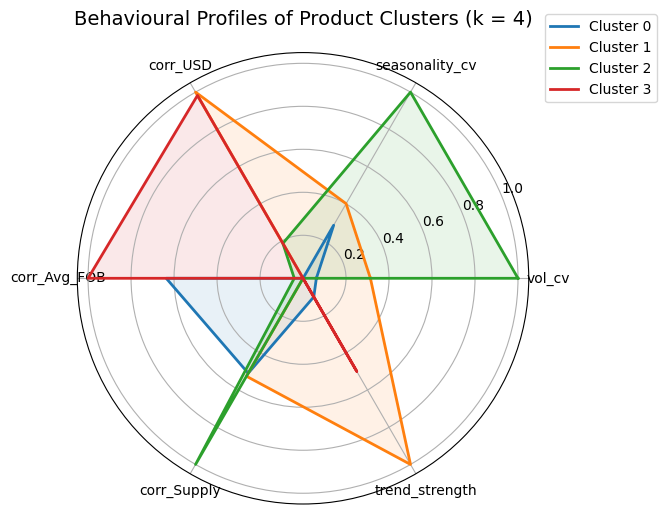

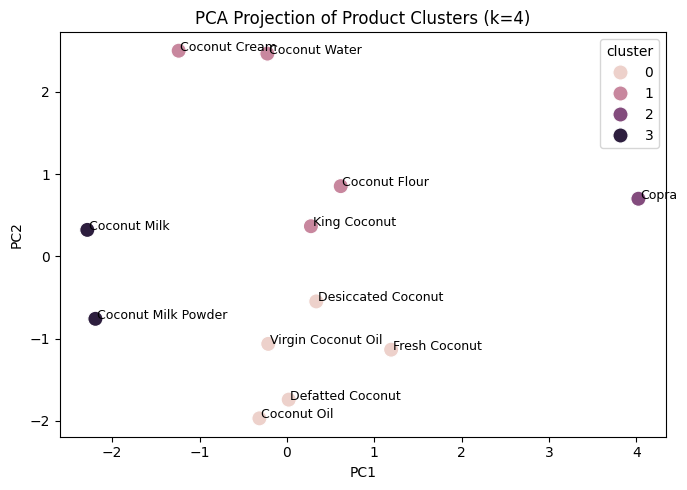

In [24]:
def plot_radar(centroids, features, title):
    num_vars = len(features)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    for cluster in centroids.index:
        values = centroids.loc[cluster].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=f"Cluster {cluster}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), features)
    ax.set_title(title, size=14, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
centroids_scaled = pd.DataFrame(
    scaler.fit_transform(centroid_table),
    columns=centroid_table.columns,
    index=centroid_table.index
)

plot_radar(
    centroids_scaled,
    cluster_features,
    title="Behavioural Profiles of Product Clusters (k = 4)"
)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)

pca_df["cluster"] = cluster_df_clean["cluster_kmeans_4"].values
pca_df["Product"] = cluster_df_clean["Product"].values

pca.explained_variance_ratio_

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    s=120
)

for i, row in pca_df.iterrows():
    plt.text(row["PC1"] + 0.02, row["PC2"], row["Product"], fontsize=9)

plt.title("PCA Projection of Product Clusters (k=4)")
plt.tight_layout()
plt.show()


Cluster 0 - driven more by market conditions and trends than by seasonality.

Cluster 01 - These products show growth + some seasonality, but are less volatile than raw products.

Cluster 02 - behaves very differently

Cluster 03 - These products have unique demand, processing, and pricing behaviour.


In [25]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler


In [26]:
def gap_statistic(X, k_range, n_refs=20):
    gaps = []
    for k in k_range:
        ref_disps = []
        for _ in range(n_refs):
            random_ref = np.random.random_sample(size=X.shape)
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            km.fit(random_ref)
            ref_disps.append(km.inertia_)

        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        km.fit(X)
        orig_disp = km.inertia_

        gap = np.log(np.mean(ref_disps)) - np.log(orig_disp)
        gaps.append(gap)
    return gaps

k_vals = range(2, 8)
gap_vals = gap_statistic(X_scaled, k_vals)

gap_df = pd.DataFrame({"k": list(k_vals), "gap": gap_vals})
gap_df

from sklearn.metrics import adjusted_rand_score


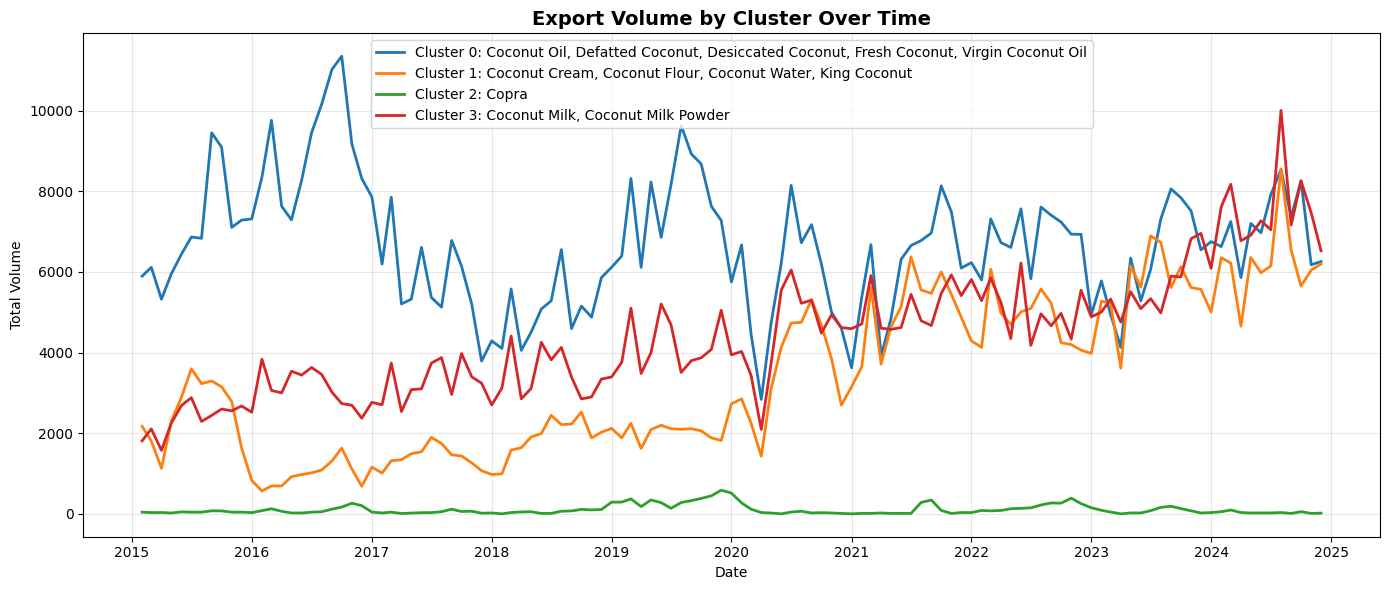

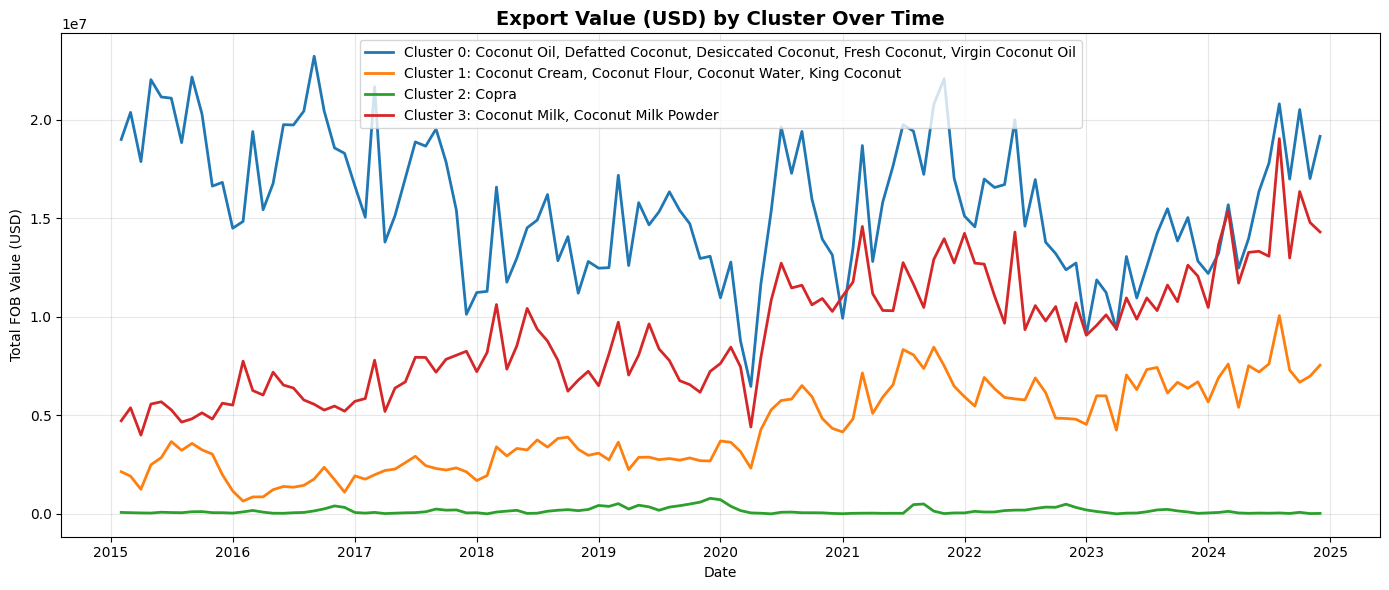

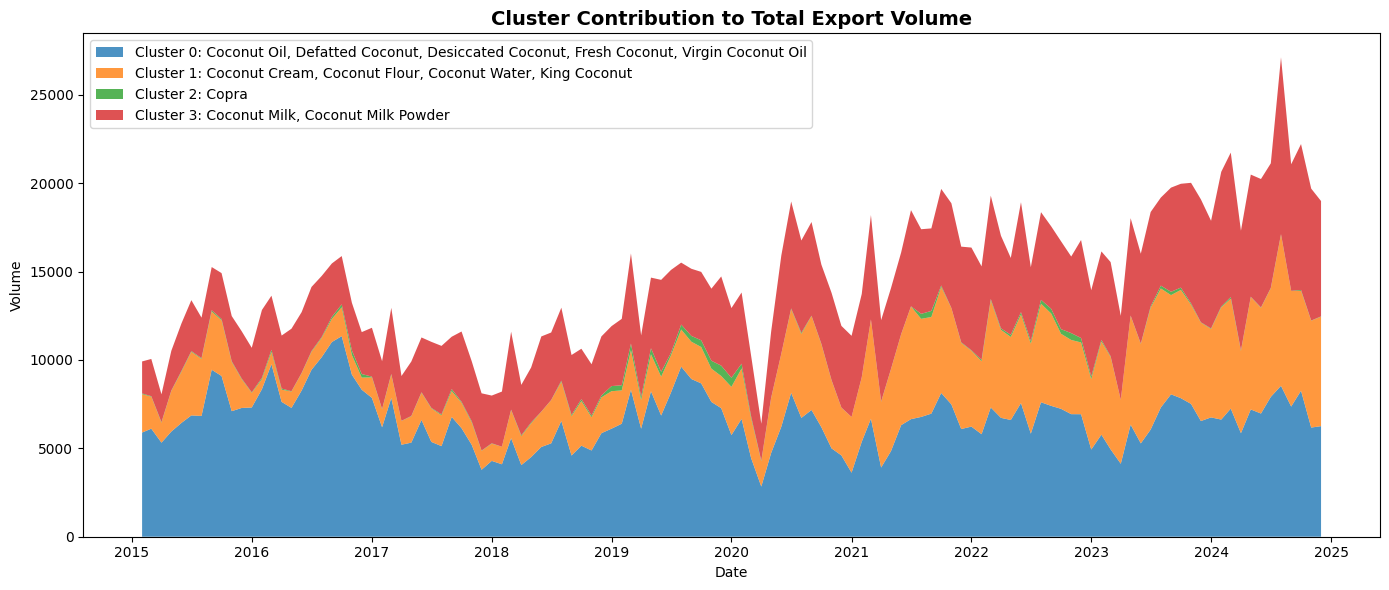

In [27]:
def bootstrap_stability(X, n_clusters, n_bootstraps=50):
    base_labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(X)
    scores = []

    for _ in range(n_bootstraps):
        idx = np.random.choice(len(X), len(X), replace=True)
        X_sample = X[idx]

        labels = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(X_sample)

        # Compare only overlapping indices
        score = adjusted_rand_score(base_labels[idx], labels)
        scores.append(score)

    return np.mean(scores), np.std(scores)

mean_stability, std_stability = bootstrap_stability(X_scaled, n_clusters=4)
mean_stability, std_stability

# Aggregate by cluster and date

# Create a mapping from Product to cluster_kmeans_4
product_to_cluster = cluster_df_clean.set_index('Product')['cluster_kmeans_4'].to_dict()

# Map the clusters back to merged_df_fe
merged_df_fe['Cluster'] = merged_df_fe['Product'].map(product_to_cluster)

# Define cluster names using the cluster_composition from earlier cells
cluster_names = {
    0: ', '.join(cluster_composition[0]).replace('Product_', ''),
    1: ', '.join(cluster_composition[1]).replace('Product_', ''),
    2: ', '.join(cluster_composition[2]).replace('Product_', ''),
    3: ', '.join(cluster_composition[3]).replace('Product_', '')
}

# Add Cluster_Name to merged_df_fe
merged_df_fe['Cluster_Name'] = merged_df_fe['Cluster'].map(cluster_names)


cluster_ts = (
    merged_df_fe
    .groupby(['Date', 'Cluster', 'Cluster_Name'])
    .agg({
        'Volume': 'sum',
        'FOB_Value_USD': 'sum'
    })
    .reset_index()
)

# Plot Volume by Cluster Over Time
plt.figure(figsize=(14, 6))

for cluster in range(4):
    subset = cluster_ts[cluster_ts['Cluster'] == cluster]
    cluster_name = subset['Cluster_Name'].iloc[0]
    plt.plot(subset['Date'], subset['Volume'],
             label=f'Cluster {cluster}: {cluster_name}', linewidth=2)

plt.title('Export Volume by Cluster Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot FOB Value by Cluster Over Time
plt.figure(figsize=(14, 6))

for cluster in range(4):
    subset = cluster_ts[cluster_ts['Cluster'] == cluster]
    cluster_name = subset['Cluster_Name'].iloc[0]
    plt.plot(subset['Date'], subset['FOB_Value_USD'],
             label=f'Cluster {cluster}: {cluster_name}', linewidth=2)

plt.title('Export Value (USD) by Cluster Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total FOB Value (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Cluster contribution over time (stacked area chart)
pivot_volume = cluster_ts.pivot(index='Date', columns='Cluster', values='Volume').fillna(0)

plt.figure(figsize=(14, 6))
plt.stackplot(pivot_volume.index,
              *[pivot_volume[i] for i in range(4)],
              labels=[f'Cluster {i}: {cluster_names[i]}' for i in range(4)],
              alpha=0.8)
plt.title('Cluster Contribution to Total Export Volume', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
